# Sliding time window laminar model comparison with two simultaneous sources

This tutorial demonstrates how to perform laminar inference of beta bursts in a sliding time window using model comparison based on free energy as a metric of model fit, described in [Bonaiuto et al., 2021, Laminar dynamics of high amplitude beta bursts in human motor cortex](https://doi.org/10.1016/j.neuroimage.2021.118479). Two temporal Gaussian functions are simulated simultaneously in deep and superficial layers at a particular cortical location. Source reconstruction is performed on the whole time window using the Empirical Bayesian Beamformer on the simulated sensor data using a forward model based on the multilayer mesh as a localizer. This is used to select priors on each layer mesh for a sliding time window model comparison using free energy.

## Setting up the simulations

Simulations are based on an existing dataset, which is used to define the sampling rate, number of trials, duration of each trial, and the channel layout.

In [1]:
%env SUBJECTS_DIR=../test_data/fs

env: SUBJECTS_DIR=../test_data/fs


In [2]:
import os
import shutil
import numpy as np
import nibabel as nib
from matplotlib import colors
import matplotlib.pyplot as plt
import k3d
import tempfile
from IPython.display import Image
import base64

from lameg.invert import coregister, invert_ebb, load_source_time_series
from lameg.laminar import sliding_window_model_comparison
from lameg.simulate import run_dipole_simulation
from lameg.surf import LayerSurfaceSet
from lameg.util import get_fiducial_coords
from lameg.viz import show_surface, color_map, rgbtoint
import spm_standalone

# Subject information for data to base the simulations on
subj_id = 'sub-104'
ses_id = 'ses-01'

# Fiducial coil coordinates
fid_coords = get_fiducial_coords(subj_id, '../test_data/participants.tsv')

# Data file to base simulations on
data_file = os.path.join(
    '../test_data', 
    subj_id, 
    'meg',
    ses_id, 
    f'spm/pspm-converted_autoreject-{subj_id}-{ses_id}-001-btn_trial-epo.mat'
)

spm = spm_standalone.initialize()

For source reconstructions, we need an MRI and a surface mesh. The simulations will be based on a forward model using the multilayer mesh, and the model comparison will use each layer mesh

In [3]:
surf_set_bilam = LayerSurfaceSet(subj_id, 2)
surf_set = LayerSurfaceSet(subj_id, 11)

verts_per_surf = surf_set.get_vertices_per_layer()

We're going to copy the data file to a temporary directory and direct all output there.

In [4]:
# Extract base name and path of data file
data_path, data_file_name = os.path.split(data_file)
data_base = os.path.splitext(data_file_name)[0]

# Where to put simulated data
tmp_dir = tempfile.mkdtemp()

# Copy data files to tmp directory
shutil.copy(
    os.path.join(data_path, f'{data_base}.mat'), 
    os.path.join(tmp_dir, f'{data_base}.mat')
)
shutil.copy(
    os.path.join(data_path, f'{data_base}.dat'), 
    os.path.join(tmp_dir, f'{data_base}.dat')
)

# Construct base file name for simulations
base_fname = os.path.join(tmp_dir, f'{data_base}.mat')

Invert the subject's data using the multilayer mesh. This step only has to be done once - this is just to compute the forward model that will be used in the simulations

In [5]:
# Patch size to use for inversion (in this case it matches the simulated patch size)
patch_size = 5
# Number of temporal modes to use for EBB inversion
n_temp_modes = 4

# Coregister data to multilayer mesh
coregister(
    fid_coords, 
    base_fname,
    surf_set,
    spm_instance=spm
)

# Run inversion
[_,_] = invert_ebb(
    base_fname, 
    surf_set, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    spm_instance=spm
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 
Initialising batch system... done.


------------------------------------------------------------------------
24-Oct-2025 07:17:51 - Running job #1
------------------------------------------------------------------------
24-Oct-2025 07:17:51 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           07:17:52 - 24/10/2025
multilayer.11.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing

model evidences relative to maximum:

ans =

     0

       priors: []
         type: 'EBB'
          woi: [-99 100]
          Han: 0
          lpf: 0
          hpf: 256
    mergeflag: 0
           Np: 512
           Nm: 274
           Nt: 4
       smooth: 5
     modality: 'MEG'
         allF: -4.0435e+05
      PostMax: [546799x1 double]
            A: [274x274 double]
           Ip: [1x512 double]
            M: [546799x274 double]
            J: {[546799x4 double]}
            L: [274x546799 double]
           qC: [546799x1 double]
        tempU: [102x102 double]
            V: [102x4 double]
           qV: [120x120 double]
            T: [120x4 double]
            U: {[274x274 double]}
           Is: [1x546799 double]
           It: [1x120 double]
           Ik: [1x60 double]
           Ic: {[1x274 double]}
           Nd: 546799
          pst: [1x120 double]
          dct: [1x102 double]
           ID: 255.0259
            F: -4.0435e+05
           R2: 99.8494
           VE: 56.9085

## Simulating a beta burst
We're going to simulate a beta burst as two dipoles. One in the deep layer, a more narrow but stronger drive in the superficial layer (see [Bonaiuto et al., 2021, Laminar dynamics of high amplitude beta bursts in human motor cortex](https://doi.org/10.1016/j.neuroimage.2021.118479))

Text(0, 0.5, 'Amplitude (nAm)')

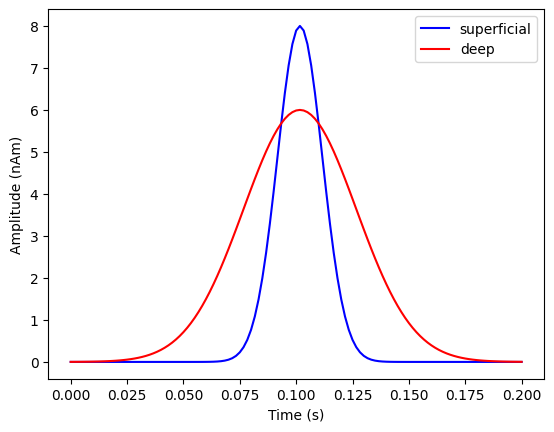

In [6]:
# Strength of each simulated source (nAm)
dipole_moment = [8, 6]
# Temporal width of the simulated superficial signal
superficial_width = .01 # 10ms
# Temporal width of the simulated deep signal
deep_width = .025 # 25ms

# Sampling rate (must match the data file)
s_rate = 600

# Generate 200ms of a Gaussian at a sampling rate of 600Hz (to match the data file)
time = np.linspace(0,.2,121)
zero_time = time[int((len(time)-1)/2+1)]
superficial_signal = np.exp(-((time-zero_time)**2)/(2*superficial_width**2))
deep_signal = np.exp(-((time-zero_time)**2)/(2*deep_width**2))

plt.plot(time,superficial_signal*dipole_moment[0], 'b', label='superficial')
plt.plot(time,deep_signal*dipole_moment[1], 'r', label='deep')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

We need to pick a location (mesh vertex) to simulate at. The superficial signal will be simulated as a dipole at the corresponding vertex on the pial surface, and the deep signal on the white matter surface. The dipole orientations will be in opposite directions (with the superficial one pointing toward the deep one, and vice versa). This will yield a cumulative dipole moment with a beta burst-like shape

In [9]:
# Location to simulate activity at
sim_vertex=24581
# Corresponding pial and white matter vertices
pial_vertex = sim_vertex
multilayer_mesh = surf_set.load(stage='ds', orientation='link_vector', fixed=True)
white_vertex = (surf_set.n_layers-1)*int(verts_per_surf)+sim_vertex
pial_coord = multilayer_mesh.darrays[0].data[pial_vertex,:]
white_coord = multilayer_mesh.darrays[0].data[white_vertex,:]

# Orientation of the simulated superficial dipole
pial_ori=multilayer_mesh.darrays[2].data[pial_vertex,:]
# Orientation of the simulated deep dipole
white_ori=-1*multilayer_mesh.darrays[2].data[white_vertex,:]

col_r = plt.cm.cool(np.linspace(0,1, num=surf_set.n_layers))

pial_mesh = surf_set.load(layer_name='pial', stage='combined')
white_mesh = surf_set.load(layer_name='white', stage='combined')

cam_view = [85.5, -10.5, 32,
            0.5, 17, 43,
            0, 0, 1]

plot = k3d.plot(
    grid_visible=False, menu_visibility=False, camera_auto_fit=False
)

pial_vertices, pial_faces, _ = pial_mesh.agg_data()
pial_k3d_mesh = k3d.mesh(pial_vertices, pial_faces, side="double", color=rgbtoint(col_r[0,:3]*255), opacity=0.5)
plot += pial_k3d_mesh

white_vertices, white_faces, _ = white_mesh.agg_data()
white_k3d_mesh = k3d.mesh(white_vertices, white_faces, side="double", color=rgbtoint(col_r[-1,:3]*255), opacity=1)
plot += white_k3d_mesh

pts = k3d.points(
    np.vstack([pial_coord, white_coord]),
    point_size=1,
    color=rgbtoint([0,0,0])
)
plot += pts

dipole_vectors = k3d.vectors(
    np.vstack([pial_coord, white_coord]),
    vectors=np.vstack([pial_ori, white_ori])*2.3,
    head_size=5,
    line_width=0.1,
    colors=[rgbtoint([0,0,255]), rgbtoint([0,0,255]),
            rgbtoint([255,0,0]), rgbtoint([255,0,0])]
)
plot += dipole_vectors

plot.camera=cam_view

plot.display()

Output()

In [10]:
plot.fetch_screenshot()

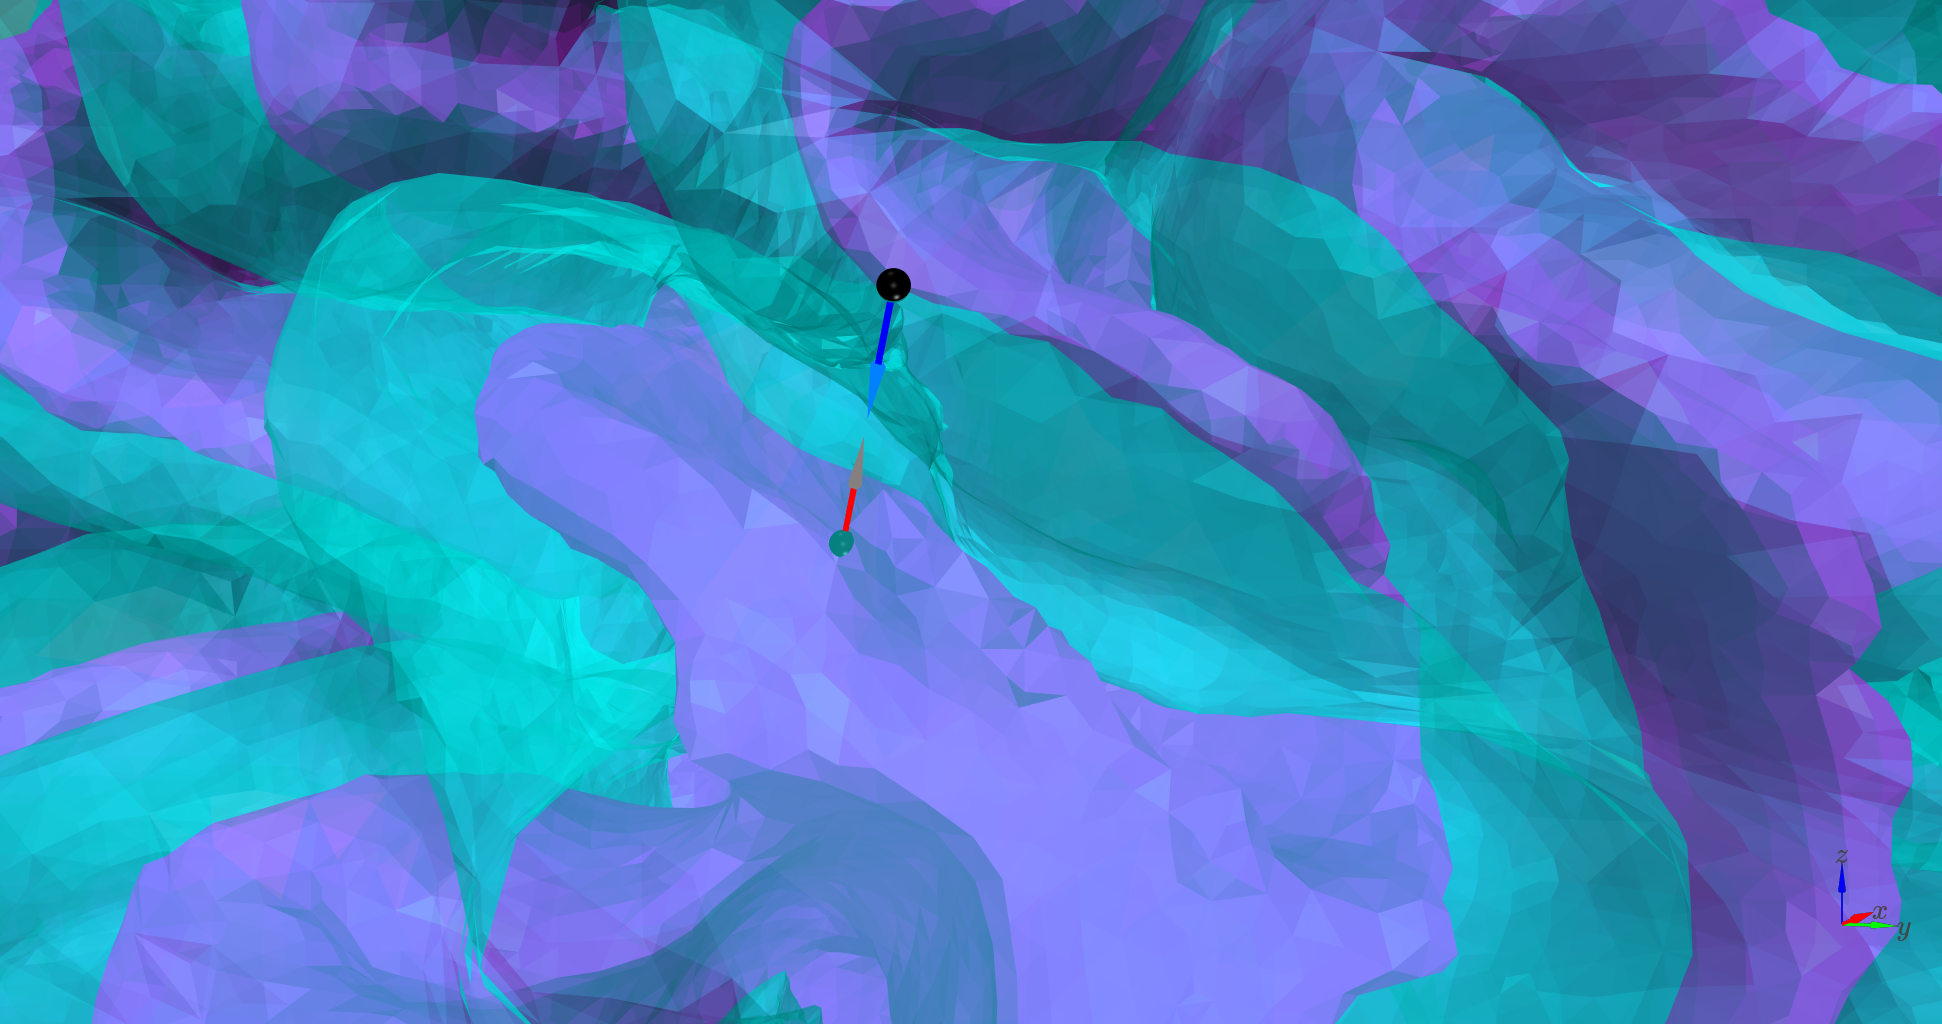

In [11]:
Image(data=base64.b64decode(plot.screenshot))

We'll simulate a 5mm patch of activity with -10 dB SNR at the sensor level. The desired level of SNR is achieved by adding white noise to the projected sensor signals

In [12]:
# Simulate a beta burst as two sources: one deep and one superficial
prefix=f'sim_{sim_vertex}_burst_'

# Size of simulated sources (mm)
sim_dipfwhm=[5, 5] # mm
# SNR of simulated data (dB)
SNR=-10

# Generate simulated data
burst_sim_fname=run_dipole_simulation(
    base_fname, 
    prefix, 
    [pial_vertex, white_vertex],
    np.vstack([superficial_signal, deep_signal]),
    np.vstack([pial_ori, white_ori]),
    dipole_moment, 
    sim_dipfwhm, 
    SNR,
    spm_instance=spm
)

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING DIPOLE SOURCES
computing surface normals
Setting white noise to give sensor level SNR of -10B

 Finish


## Localizer inversion
Now we'll run a source reconstruction using the multilayer mesh, extract the signal in the pial layer, and select a prior based on the peak.

In [13]:
[_,_,MU] = invert_ebb(
    burst_sim_fname, 
    surf_set, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    return_mu_matrix=True,
    spm_instance=spm
)

layer_vertices = np.arange(verts_per_surf)
layer_ts, time, _ = load_source_time_series(
    burst_sim_fname, 
    mu_matrix=MU, 
    vertices=layer_vertices
)

# Layer peak
m_layer_max = np.max(np.mean(layer_ts,axis=-1),-1)
prior = np.argmax(m_layer_max)

print(f'Simulated vertex={sim_vertex}, Prior vertex={prior}')

Smoothing ../test_data/fs/sub-104/surf/laminar/multilayer.11.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_multilayer.11.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_multilayer.11.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmpeydu_zut/sim_24581_burst_pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have b

We can see that the prior is the same as the location we simulated at

In [14]:
# Interpolate for display on the original inflated surface
interpolated_data = surf_set.interpolate_layer_data('pial', m_layer_max, from_stage='ds', to_stage='combined')
          
inflated_ds_mesh = surf_set.load('inflated', stage='ds')
coord = inflated_ds_mesh.darrays[0].data[prior,:]

# Plot colors and camera view
max_abs = np.max(np.abs(interpolated_data))
c_range = [-max_abs, max_abs]
cam_view = [335, 9.5, 51,
            60, 37, 17,
            0, 0, 1]

# Plot peak
colors,_ = color_map(
    interpolated_data, 
    "RdYlBu_r", 
    c_range[0], 
    c_range[1]    
)
thresh_colors=np.ones((colors.shape[0],4))*255
thresh_colors[:,:3]=colors
thresh_colors[interpolated_data<np.percentile(interpolated_data,99.9),3]=0

plot = show_surface(
    surf_set, 
    vertex_colors=thresh_colors, 
    info=True, 
    camera_view=cam_view, 
    marker_coords=coord, 
    marker_size=5, 
    marker_color=[0,0,255]
)

Output()

507832 vertices


In [15]:
plot.fetch_screenshot()

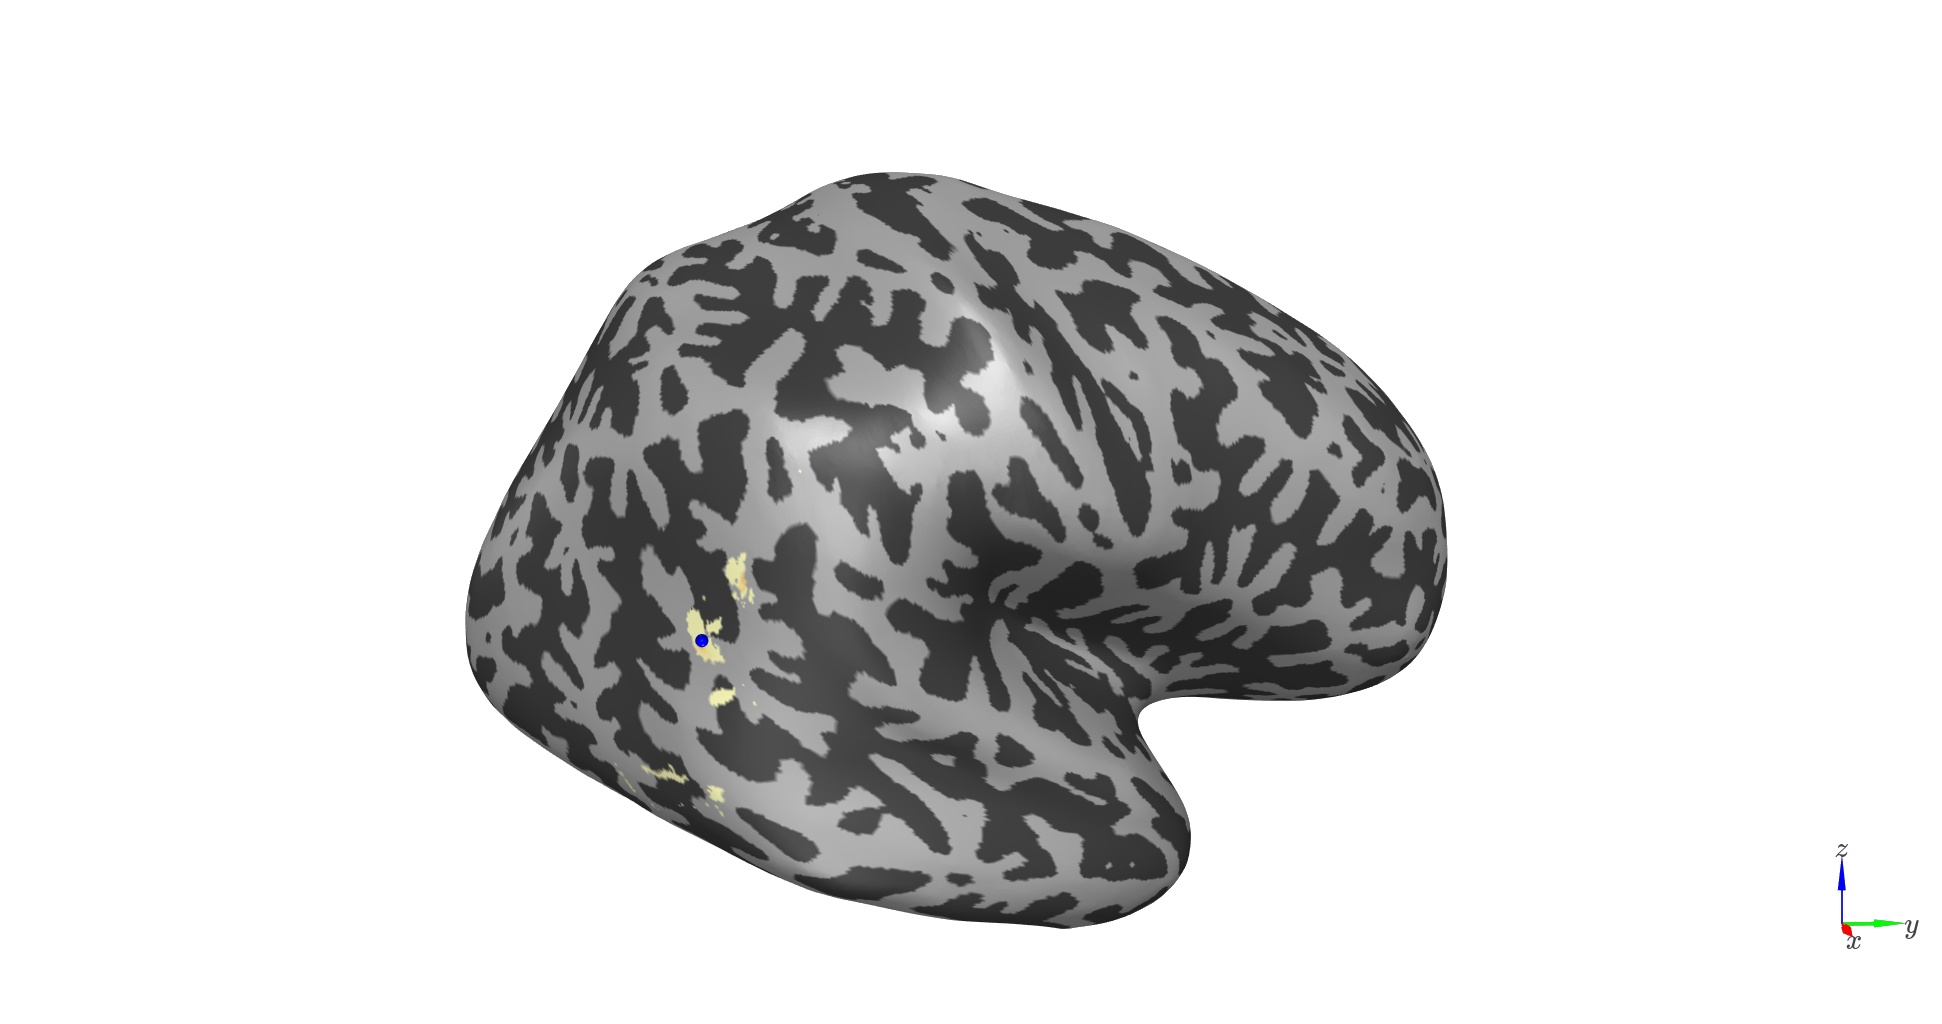

In [16]:
Image(data=base64.b64decode(plot.screenshot))

## Sliding time window model comparison (pial - white matter)
Now we can run sliding time window model comparison between source models based on the pial and white matter surfaces using free energy. Specifically, we'll look at the difference in free energy between the two models (pial - white matter), in sliding and overlapping windows of 16ms. Because this window is so short, we'll use 2 temporal modes. If you increase the size of the window, you may have to increase the number of temporal modes. The free energy difference (pial - white matter) should be negative (more model evidence for the white matter surface model) at the start and end of the burst, and positive (more model evidence for the pial surface model) at the peak of the burst.

In [18]:
# Number of temporal models for sliding time window inversion
sliding_n_temp_modes = 4
# Size of sliding window (in ms)
win_size = 16
# Whether or not windows overlap
win_overlap = True

# Run sliding time window model comparison between the first layer (pial) and the last layer (white matter)
[Fs,wois] = sliding_window_model_comparison(
    prior, 
    fid_coords, 
    burst_sim_fname, 
    surf_set_bilam,
    spm_instance=spm,
    invert_kwargs={
        'patch_size': patch_size, 
        'n_temp_modes': sliding_n_temp_modes,
        'win_size': win_size, 
        'win_overlap': win_overlap    
    }
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
24-Oct-2025 07:52:36 - Running job #2
------------------------------------------------------------------------
24-Oct-2025 07:52:36 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           07:52:52 - 24/10/2025
pial.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing for the gradiometer definition
creating lay

  ReML Iteration              : 2                            ...8.517303e+01
  ReML Iteration              : 3                            ...7.197615e+01
  ReML Iteration              : 4                            ...6.264137e+01
  ReML Iteration              : 5                            ...5.486615e+01
  ReML Iteration              : 6                            ...4.758022e+01
  ReML Iteration              : 7                            ...4.027349e+01
  ReML Iteration              : 8                            ...3.282748e+01
  ReML Iteration              : 9                            ...2.545848e+01
  ReML Iteration              : 10                            ...1.861324e+01
  ReML Iteration              : 11                            ...1.277157e+01
  ReML Iteration              : 12                            ...8.233608e+00
  ReML Iteration              : 13                            ...5.019583e+00
  ReML Iteration              : 14                            ...2.92408

  ReML Iteration              : 29                            ...1.732354e-05
Inverting subject 1
  ReML Iteration 1                      :        ...1.219460e+02 [+4.12]
Inverting subject 1
  ReML Iteration 1                      :        ...1.219460e+02 [+4.12]
  ReML Iteration              : 2                            ...8.498278e+01
  ReML Iteration              : 3                            ...7.164768e+01
  ReML Iteration              : 4                            ...6.211612e+01
  ReML Iteration              : 5                            ...5.407942e+01
  ReML Iteration              : 6                            ...4.647736e+01
  ReML Iteration              : 7                            ...3.883687e+01
  ReML Iteration              : 8                            ...3.110649e+01
  ReML Iteration              : 9                            ...2.358241e+01
  ReML Iteration              : 10                            ...1.676553e+01
  ReML Iteration              : 11        

  ReML Iteration              : 24                            ...4.040483e-01
  ReML Iteration              : 25                            ...5.828994e-05
Inverting subject 1
  ReML Iteration 1                      :        ...1.219184e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194311e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171637e+02 [+4.38]
  ReML Iteration 4                      :        ...1.116816e+02 [+4.50]
  ReML Iteration 5                      :        ...2.161789e-05 [+4.62]
Percent variance explained -42.33 (-42.33)
  ReML Iteration 2                      :        ...1.194034e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170900e+02 [+4.38]
  ReML Iteration 4                      :        ...1.114927e+02 [+4.50]
  ReML Iteration 5                      :        ...4.091136e-04 [+4.62]
Percent variance explained -25.19 (-24.57)
  ReML Iteration 2                      :        ...1.194034e+02 [+4.25]
  ReML I

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.11 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.645655e+03 [+4.12]
  ReML Iteration 2                      :        ...1.327845e+02 [+4.25]
  ReML Iteration 3                      :        ...8.598591e+00 [+4.38]
  ReML Iteration 4                      :        ...2.358300e-01 [+4.50]
  ReML Iteration 5                      :        ...1.525736e-04 [+4.62]
log evidence & hyperparameters:
    0.00 6125.65
    9.44    0.01

  ReML Iteration              : 1                            ...1.065878e+03
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.54 percent averag

  ReML Iteration              : 2                            ...6.106898e+01
  ReML Iteration              : 3                            ...1.391610e+01
  ReML Iteration              : 4                            ...3.782038e+00
  ReML Iteration              : 5                            ...9.929455e-01
  ReML Iteration              : 6                            ...2.633109e-01
  ReML Iteration              : 7                            ...7.328304e-02
  ReML Iteration              : 8                            ...2.167562e-02
  ReML Iteration              : 9                            ...6.807629e-03
Inverting subject 1
  ReML Iteration              : 2                            ...1.244350e+02
  ReML Iteration              : 3                            ...1.370541e+01
  ReML Iteration              : 4                            ...2.296969e+00
  ReML Iteration              : 5                            ...4.681962e-01
  ReML Iteration              : 6                       

  ReML Iteration 1                      :        ...2.567792e+03 [+4.12]
  ReML Iteration 2                      :        ...1.239877e+02 [+4.25]
  ReML Iteration 3                      :        ...1.597728e+01 [+4.38]
  ReML Iteration 4                      :        ...8.530296e-01 [+4.50]
  ReML Iteration 5                      :        ...1.559001e-03 [+4.62]
Percent variance explained 94.08 (80.48)
  ReML Iteration 1                      :        ...3.526101e+03 [+4.12]
  ReML Iteration 2                      :        ...1.891641e+02 [+4.25]
  ReML Iteration 3                      :        ...1.116349e+01 [+4.38]
  ReML Iteration 4                      :        ...3.700833e-01 [+4.50]
  ReML Iteration 5                      :        ...2.630754e-04 [+4.62]
Percent variance explained 95.11 (81.86)
  ReML Iteration 1                      :        ...3.571198e+03 [+4.12]
  ReML Iteration 2                      :        ...1.930250e+02 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration 1                      :        ...1.630448e+04 [+4.12]
  ReML Iteration 2                      :        ...5.342336e+03 [+4.25]
  ReML Iteration 3                      :        ...3.829426e+02 [+4.38]
  ReML Iteration 4                      :        ...1.341438e+00 [+4.50]
  ReML Iteration 5                      :        ...1.443756e-05 [+4.62]
Percent variance explained 97.78 (90.74)
  ReML Iteration 1                      :        ...6.323891e+03 [+4.12]
  ReML Iteration 2                      :        ...5.778955e+02 [+4.25]
  ReML Iteration 3                      :        ...7.367893e+00 [+4.38]
  ReML Iteration 4                      :        ...5.531094e-02 [+4.50]
  ReML Iteration 5                      :        ...3.826174e-06 [+4.62]
Percent variance explained 90.04 (81.02)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.65 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1         

  ReML Iteration              : 2                            ...8.060140e+01
  ReML Iteration              : 3                            ...6.429049e+01
  ReML Iteration              : 4                            ...5.098378e+01
  ReML Iteration              : 5                            ...3.876356e+01
  ReML Iteration              : 6                            ...2.745318e+01
  ReML Iteration              : 7                            ...1.771201e+01
  ReML Iteration              : 8                            ...1.028325e+01
  ReML Iteration              : 9                            ...5.378139e+00
  ReML Iteration              : 10                            ...2.569853e+00
  ReML Iteration              : 11                            ...1.147636e+00
  ReML Iteration              : 12                            ...4.909025e-01
  ReML Iteration              : 13                            ...2.054414e-01
  ReML Iteration              : 14                            ...8.54359

  ReML Iteration 1                      :        ...1.759678e+04 [+4.12]
  ReML Iteration 2                      :        ...6.466134e+03 [+4.25]
  ReML Iteration 3                      :        ...5.933945e+02 [+4.38]
  ReML Iteration 4                      :        ...3.349154e+00 [+4.50]
  ReML Iteration 5                      :        ...9.100345e-05 [+4.62]
Percent variance explained 97.71 (91.50)
  ReML Iteration              : 2                            ...1.684011e+03
  ReML Iteration              : 3                            ...2.518510e+02
  ReML Iteration              : 4                            ...4.147821e+01
  ReML Iteration              : 5                            ...8.128083e+00
  ReML Iteration              : 6                            ...1.860195e+00
  ReML Iteration              : 7                            ...4.816827e-01
  ReML Iteration              : 8                            ...1.374675e-01
  ReML Iteration              : 9                      

  ReML Iteration 1                      :        ...1.607753e+04 [+4.12]
  ReML Iteration 2                      :        ...5.159045e+03 [+4.25]
  ReML Iteration 3                      :        ...3.536724e+02 [+4.38]
  ReML Iteration 4                      :        ...1.137001e+00 [+4.50]
  ReML Iteration 5                      :        ...1.035299e-05 [+4.62]
Percent variance explained 97.87 (93.54)
  ReML Iteration 1                      :        ...1.041907e+04 [+4.12]
  ReML Iteration 2                      :        ...1.798808e+03 [+4.25]
  ReML Iteration 3                      :        ...3.538437e+01 [+4.38]
  ReML Iteration 4                      :        ...1.580517e-02 [+4.50]
  ReML Iteration 5                      :        ...5.464629e-09 [+4.62]
Percent variance explained 93.18 (83.30)
  ReML Iteration 1                      :        ...2.119789e+02 [+4.12]
  ReML Iteration 2                      :        ...1.048382e+02 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration 1                      :        ...1.295456e+02 [+4.12]
  ReML Iteration 2                      :        ...1.158626e+02 [+4.25]
  ReML Iteration 3                      :        ...1.079230e+02 [+4.38]
  ReML Iteration 4                      :        ...8.964712e+01 [+4.50]
  ReML Iteration 5                      :        ...5.579005e+01 [+4.62]
  ReML Iteration 6                      :        ...4.241590e+00 [+4.75]
  ReML Iteration 7                      :        ...1.369636e-04 [+4.88]
Percent variance explained -885.77 (-740.96)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.64 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...7.004702e+02

  ReML Iteration              : 2                            ...7.846916e+01
  ReML Iteration              : 3                            ...6.084658e+01
  ReML Iteration              : 4                            ...4.618061e+01
  ReML Iteration              : 5                            ...3.294028e+01
  ReML Iteration              : 6                            ...2.142396e+01
  ReML Iteration              : 7                            ...1.246794e+01
  ReML Iteration              : 8                            ...6.471803e+00
  ReML Iteration              : 9                            ...3.036931e+00
  ReML Iteration              : 10                            ...1.321173e+00
  ReML Iteration              : 11                            ...5.481973e-01
  ReML Iteration              : 12                            ...2.223419e-01
  ReML Iteration              : 13                            ...8.971859e-02
  ReML Iteration              : 14                            ...3.64207

  ReML Iteration              : 2                            ...5.999890e+01
  ReML Iteration              : 3                            ...3.345869e+01
  ReML Iteration              : 4                            ...1.661023e+01
  ReML Iteration              : 5                            ...7.013649e+00
  ReML Iteration              : 6                            ...2.592728e+00
  ReML Iteration              : 7                            ...8.871006e-01
  ReML Iteration              : 8                            ...2.958154e-01
  ReML Iteration              : 9                            ...9.942693e-02
  ReML Iteration              : 10                            ...3.426235e-02
  ReML Iteration              : 11                            ...1.218503e-02
  ReML Iteration              : 12                            ...4.477636e-03
Inverting subject 1
  ReML Iteration              : 2                            ...5.057717e+03
  ReML Iteration              : 3                    

  ReML Iteration 1                      :        ...3.383644e+02 [+4.12]
  ReML Iteration 2                      :        ...9.714191e+01 [+4.25]
  ReML Iteration 3                      :        ...6.657670e+01 [+4.38]
  ReML Iteration 4                      :        ...2.564367e+01 [+4.50]
  ReML Iteration 5                      :        ...2.624896e+00 [+4.62]
  ReML Iteration 6                      :        ...1.830609e-02 [+4.75]
  ReML Iteration 7                      :        ...5.963127e-07 [+4.88]
Percent variance explained 82.72 (74.16)
  ReML Iteration 1                      :        ...1.718176e+04 [+4.12]
  ReML Iteration 2                      :        ...6.090110e+03 [+4.25]
  ReML Iteration 3                      :        ...5.168917e+02 [+4.38]
  ReML Iteration 4                      :        ...2.508136e+00 [+4.50]
  ReML Iteration 5                      :        ...5.084708e-05 [+4.62]
Percent variance explained 96.99 (90.97)
  ReML Iteration              : 2         

model evidences relative to maximum:

ans =

   1.0e+03 *

  Columns 1 through 7

   -4.3304   -4.1389   -4.1321   -4.1162   -4.0363   -4.0363   -3.9305

  Columns 8 through 14

   -3.8921   -3.8478   -3.8137   -3.8042   -3.8037   -3.7757   -3.7338

  Columns 15 through 21

   -3.7228   -3.7155   -3.6982   -3.6678   -3.6638   -3.6275   -3.6263

  Columns 22 through 28

   -3.5483   -3.5337   -3.4793   -3.3992   -3.3499   -3.3480   -3.3368

  Columns 29 through 35

   -3.2960   -3.2162   -3.1808   -3.0097   -2.9770   -2.8955   -2.5044

  Columns 36 through 42

   -2.4704   -2.4381   -2.3941   -2.2651   -2.2056   -2.1104   -1.9263

  Columns 43 through 49

   -1.9022   -1.8897   -1.7339   -1.7295   -1.7241   -1.7044   -1.6791

  Columns 50 through 56

   -1.5421   -1.5381   -1.5111   -1.4649   -1.3871   -1.3568   -1.3144

  Columns 57 through 63

   -1.2622   -1.2287   -1.1986   -1.1343   -1.1221   -1.1144   -1.0988

  Columns 64 through 70

   -1.0159   -1.0116   -1.0019   -0.9677   -0.

Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.51 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.851707e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186309e+02 [+4.25]
  ReML Iteration 3                      :        ...1.125385e+02 [+4.38]
  ReML Iteration 4                      :        ...1.026022e+02 [+4.50]
  ReML Iteration 5                      :        ...8.091680e+01 [+4.62]
  ReML Iteration 6                      :        ...6.254438e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.48   -2.82

  ReML Iteration              : 1                            ...1.085719e+02
Fixed number of temporal modes
Using 4 temporal modes, acco

  ReML Iteration              : 2                            ...8.515656e+01
  ReML Iteration              : 3                            ...7.194767e+01
  ReML Iteration              : 4                            ...6.259575e+01
  ReML Iteration              : 5                            ...5.479758e+01
  ReML Iteration              : 6                            ...4.748360e+01
  ReML Iteration              : 7                            ...4.014670e+01
  ReML Iteration              : 8                            ...3.267407e+01
  ReML Iteration              : 9                            ...2.528907e+01
  ReML Iteration              : 10                            ...1.844372e+01
  ReML Iteration              : 11                            ...1.261797e+01
  ReML Iteration              : 12                            ...8.106693e+00
  ReML Iteration              : 13                            ...4.922499e+00
  ReML Iteration              : 14                            ...2.85391

  ReML Iteration 1                      :        ...1.219309e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194185e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171301e+02 [+4.38]
  ReML Iteration 4                      :        ...1.115954e+02 [+4.50]
  ReML Iteration 5                      :        ...1.382388e-04 [+4.62]
Percent variance explained -38.92 (-38.92)
  ReML Iteration 1                      :        ...1.219734e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193763e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170179e+02 [+4.38]
  ReML Iteration 4                      :        ...1.113085e+02 [+4.50]
  ReML Iteration 5                      :        ...1.256703e-03 [+4.62]
Percent variance explained -24.40 (-23.79)
  ReML Iteration 1                      :        ...1.219734e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193763e+02 [+4.25]
  ReML Iteration 3                    

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.08 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.411346e+03 [+4.12]
  ReML Iteration 2                      :        ...4.770416e+02 [+4.25]
  ReML Iteration 3                      :        ...3.762633e+00 [+4.38]
  ReML Iteration 4                      :        ...2.966614e-03 [+4.50]
log evidence & hyperparameters:
    0.00 12274.36
    9.41    1.37

  ReML Iteration              : 1                            ...3.176239e+03
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 88.31 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1    

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.11 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.680873e+03 [+4.12]
  ReML Iteration 2                      :        ...1.350006e+02 [+4.25]
  ReML Iteration 3                      :        ...8.337558e+00 [+4.38]
  ReML Iteration 4                      :        ...2.201565e-01 [+4.50]
  ReML Iteration 5                      :        ...1.332741e-04 [+4.62]
log evidence & hyperparameters:
    0.00 6212.44
    9.44    0.60

  ReML Iteration              : 1                            ...1.089557e+03
  ReML Iteration              : 2                            ...6.177313e+01
  ReML Iteration              : 3 

  ReML Iteration 1                      :        ...3.616240e+03 [+4.12]
  ReML Iteration 2                      :        ...1.969545e+02 [+4.25]
  ReML Iteration 3                      :        ...1.083634e+01 [+4.38]
  ReML Iteration 4                      :        ...3.444554e-01 [+4.50]
  ReML Iteration 5                      :        ...2.255451e-04 [+4.62]
Percent variance explained 96.38 (82.96)
  ReML Iteration              : 2                            ...2.187023e+02
  ReML Iteration              : 3                            ...2.135546e+01
  ReML Iteration              : 4                            ...3.114638e+00
  ReML Iteration              : 5                            ...5.881190e-01
  ReML Iteration              : 6                            ...1.327555e-01
  ReML Iteration              : 7                            ...3.416876e-02
  ReML Iteration              : 8                            ...9.722049e-03
Inverting subject 1
  ReML Iteration              : 2  

  ReML Iteration 1                      :        ...1.283913e+03 [+4.12]
  ReML Iteration 2                      :        ...8.521440e+01 [+4.25]
  ReML Iteration 3                      :        ...3.010462e+01 [+4.38]
  ReML Iteration 4                      :        ...3.708411e+00 [+4.50]
  ReML Iteration 5                      :        ...3.569040e-02 [+4.62]
  ReML Iteration 6                      :        ...1.824732e-06 [+4.75]
Percent variance explained 92.66 (83.49)
  ReML Iteration 1                      :        ...2.628791e+03 [+4.12]
  ReML Iteration 2                      :        ...1.271969e+02 [+4.25]
  ReML Iteration 3                      :        ...1.558024e+01 [+4.38]
  ReML Iteration 4                      :        ...8.050883e-01 [+4.50]
  ReML Iteration 5                      :        ...1.378812e-03 [+4.62]
Percent variance explained 95.28 (81.50)
  ReML Iteration 1                      :        ...3.663252e+03 [+4.12]
  ReML Iteration 2                      : 

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 88.11 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.108944e+04 [+4.12]
  ReML Iteration 2                      :        ...2.407912e+03 [+4.25]
  ReML Iteration 3                      :        ...9.484273e+01 [+4.38]
  ReML Iteration 4                      :        ...1.360626e-01 [+4.50]
  ReML Iteration 5                      :        ...2.743508e-07 [+4.62]
log evidence & hyperparameters:
    0.00 23746.95
    9.34    2.25

  ReML Iteration              : 1                            ...8.225472e+03
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.03 percent avera

  ReML Iteration 1                      :        ...1.139976e+04 [+4.12]
  ReML Iteration 2                      :        ...2.228333e+03 [+4.25]
  ReML Iteration 3                      :        ...5.532960e+01 [+4.38]
  ReML Iteration 4                      :        ...2.830768e-02 [+4.50]
  ReML Iteration 5                      :        ...4.497990e-09 [+4.62]
Percent variance explained 89.93 (85.46)
  ReML Iteration              : 2                            ...5.808255e+03
  ReML Iteration              : 3                            ...1.584162e+03
  ReML Iteration              : 4                            ...3.713112e+02
  ReML Iteration              : 5                            ...8.611634e+01
  ReML Iteration              : 6                            ...2.128868e+01
  ReML Iteration              : 7                            ...5.716359e+00
  ReML Iteration              : 8                            ...1.660869e+00
  ReML Iteration              : 9                      

  ReML Iteration 1                      :        ...5.844195e+03 [+4.12]
  ReML Iteration 2                      :        ...4.883778e+02 [+4.25]
  ReML Iteration 3                      :        ...7.153859e+00 [+4.38]
  ReML Iteration 4                      :        ...7.382781e-02 [+4.50]
  ReML Iteration 5                      :        ...7.517107e-06 [+4.62]
Percent variance explained 86.89 (78.45)
  ReML Iteration 1                      :        ...9.185065e+03 [+4.12]
  ReML Iteration 2                      :        ...1.338150e+03 [+4.25]
  ReML Iteration 3                      :        ...1.985716e+01 [+4.38]
  ReML Iteration 4                      :        ...1.431924e-02 [+4.50]
  ReML Iteration 5                      :        ...5.837157e-08 [+4.62]
Percent variance explained 94.91 (83.62)
  ReML Iteration              : 2                            ...9.195795e+02
  ReML Iteration              : 3                            ...1.129010e+02
  ReML Iteration              : 4 

  ReML Iteration 1                      :        ...1.825485e+04 [+4.12]
  ReML Iteration 2                      :        ...7.092583e+03 [+4.25]
  ReML Iteration 3                      :        ...7.350788e+02 [+4.38]
  ReML Iteration 4                      :        ...5.253919e+00 [+4.50]
  ReML Iteration 5                      :        ...2.253977e-04 [+4.62]
Percent variance explained 98.95 (92.93)
  ReML Iteration 1                      :        ...7.793376e+03 [+4.12]
  ReML Iteration 2                      :        ...9.176977e+02 [+4.25]
  ReML Iteration 3                      :        ...1.084025e+01 [+4.38]
  ReML Iteration 4                      :        ...2.466858e-02 [+4.50]
  ReML Iteration 5                      :        ...4.868250e-07 [+4.62]
Percent variance explained 92.40 (79.57)
  ReML Iteration 1                      :        ...1.428897e+04 [+4.12]
  ReML Iteration 2                      :        ...3.854151e+03 [+4.25]
  ReML Iteration 3                      : 

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.79 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.924898e+04 [+4.12]
  ReML Iteration 2                      :        ...8.906804e+03 [+4.25]
  ReML Iteration 3                      :        ...1.766443e+03 [+4.38]
  ReML Iteration 4                      :        ...7.723096e+01 [+4.50]
  ReML Iteration 5                      :        ...1.775721e-01 [+4.62]
  ReML Iteration 6                      :        ...9.998954e-07 [+4.75]
log evidence & hyperparameters:
    0.00 42833.69
    8.94    3.14

  ReML Iteration              : 1                            ...1.610573e+04
  ReML Iteration 1                   

  ReML Iteration              : 2                            ...5.496088e+03
  ReML Iteration              : 3                            ...1.449324e+03
  ReML Iteration              : 4                            ...3.313663e+02
  ReML Iteration              : 5                            ...7.579590e+01
  ReML Iteration              : 6                            ...1.860949e+01
  ReML Iteration              : 7                            ...4.980267e+00
  ReML Iteration              : 8                            ...1.444574e+00
  ReML Iteration              : 9                            ...4.493247e-01
  ReML Iteration              : 10                            ...1.483155e-01
  ReML Iteration              : 11                            ...5.149447e-02
  ReML Iteration              : 12                            ...1.866933e-02
  ReML Iteration              : 13                            ...7.026454e-03
Inverting subject 1
  ReML Iteration              : 2                   

  ReML Iteration              : 2                            ...7.397696e+01
  ReML Iteration              : 3                            ...1.238921e+01
  ReML Iteration              : 4                            ...2.822572e+00
  ReML Iteration              : 5                            ...6.738330e-01
  ReML Iteration              : 6                            ...1.701232e-01
  ReML Iteration              : 7                            ...4.618737e-02
  ReML Iteration              : 8                            ...1.348942e-02
  ReML Iteration              : 9                            ...4.208633e-03
Inverting subject 1
  ReML Iteration              : 2                            ...4.042760e+03
  ReML Iteration              : 3                            ...8.954125e+02
  ReML Iteration              : 4                            ...1.818837e+02
  ReML Iteration              : 5                            ...3.911909e+01
  ReML Iteration              : 6                       

  ReML Iteration 1                      :        ...1.781970e+04 [+4.12]
  ReML Iteration 2                      :        ...6.674149e+03 [+4.25]
  ReML Iteration 3                      :        ...6.384391e+02 [+4.38]
  ReML Iteration 4                      :        ...3.905283e+00 [+4.50]
  ReML Iteration 5                      :        ...1.239954e-04 [+4.62]
Percent variance explained 98.80 (92.67)
  ReML Iteration 1                      :        ...1.566041e+04 [+4.12]
  ReML Iteration 2                      :        ...4.832809e+03 [+4.25]
  ReML Iteration 3                      :        ...3.049226e+02 [+4.38]
  ReML Iteration 4                      :        ...8.357271e-01 [+4.50]
  ReML Iteration 5                      :        ...5.574112e-06 [+4.62]
Percent variance explained 99.03 (91.26)
  ReML Iteration 1                      :        ...8.934901e+03 [+4.12]
  ReML Iteration 2                      :        ...1.255074e+03 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration 1                      :        ...1.648237e+03 [+4.12]
  ReML Iteration 2                      :        ...9.061775e+01 [+4.25]
  ReML Iteration 3                      :        ...2.452033e+01 [+4.38]
  ReML Iteration 4                      :        ...2.292606e+00 [+4.50]
  ReML Iteration 5                      :        ...1.274578e-02 [+4.62]
  ReML Iteration 6                      :        ...1.485366e-07 [+4.75]
Percent variance explained 94.05 (79.58)
  ReML Iteration 1                      :        ...1.269250e+04 [+4.12]
  ReML Iteration 2                      :        ...2.886444e+03 [+4.25]
  ReML Iteration 3                      :        ...9.671404e+01 [+4.38]
  ReML Iteration 4                      :        ...7.987334e-02 [+4.50]
  ReML Iteration 5                      :        ...4.820564e-08 [+4.62]
Percent variance explained 98.83 (93.24)
  ReML Iteration 1                      :        ...1.788774e+04 [+4.12]
  ReML Iteration 2                      : 

24-Oct-2025 07:55:48 - Done    'Source inversion, iterative'
24-Oct-2025 07:55:48 - Done



Text(0, 0.5, '$\\Delta$F')

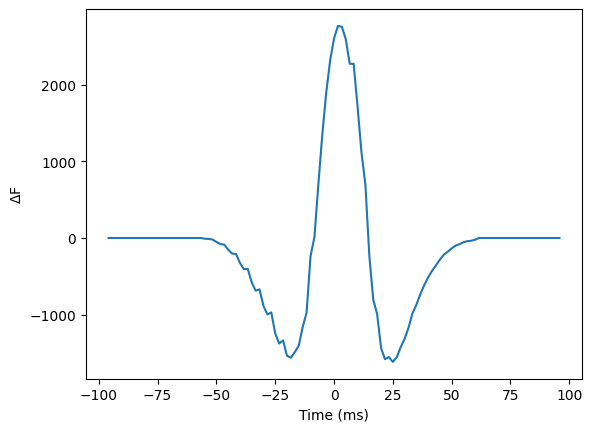

In [19]:
# Plot difference in free energy over time (pial minus white) - this should be negative at the beginning and end 
# of the burst, and positive at the center
plt.plot(np.mean(wois,axis=-1), Fs[0,:]-Fs[1,:])
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')

## Sliding time window model comparison across layers
That was sliding time window model comparison with two candidate models: one based on the white matter surface, and one on the pial. Let's run it across all layers. We'll turn off SPM visualization here.

In [20]:
# Run sliding window model comparison across all layers
[Fs,wois] = sliding_window_model_comparison(
    prior, 
    fid_coords, 
    burst_sim_fname, 
    surf_set,
    viz=False,
    spm_instance=spm,
    invert_kwargs={
        'patch_size': patch_size, 
        'n_temp_modes': sliding_n_temp_modes,
        'win_size': win_size, 
        'win_overlap': win_overlap    
    }
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
24-Oct-2025 07:55:49 - Running job #2
------------------------------------------------------------------------
24-Oct-2025 07:55:49 - Running 'Head model specification'
pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           07:56:21 - 24/10/2025
Completed                               :          07:56:21 - 24/10/2025
24-Oct-2025 07:56:22 - Done    'Head model specification'
24-Oct-2025 07:56:22 - Done

  ReML Iteration              : 2                            ...8.517303e+01
  ReML Iteration              : 3                            ...7.197615e+01
  ReML Iteration              : 4                            ...6.264137e+01
  ReML Iteration              : 5                            ...5.486615e+01
  ReML Iteration              : 6                            ...4.758022e+01
  ReML Iteration              : 7                            ...4.027349e+01
  ReML Iteration              : 8                            ...3.282748e+01
  ReML Iteration              : 9                            ...2.545848e+01
  ReML Iteration              : 10                            ...1.861324e+01
  ReML Iteration              : 11                            ...1.277157e+01
  ReML Iteration              : 12                            ...8.233608e+00
  ReML Iteration              : 13                            ...5.019583e+00
  ReML Iteration              : 14                            ...2.92408

  ReML Iteration 1                      :        ...1.219184e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194311e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171637e+02 [+4.38]
  ReML Iteration 4                      :        ...1.116816e+02 [+4.50]
  ReML Iteration 5                      :        ...2.161789e-05 [+4.62]
Percent variance explained -42.33 (-42.33)
  ReML Iteration              : 2                            ...8.513694e+01
  ReML Iteration              : 3                            ...7.191377e+01
  ReML Iteration              : 4                            ...6.254143e+01
  ReML Iteration              : 5                            ...5.471601e+01
  ReML Iteration              : 6                            ...4.736880e+01
  ReML Iteration              : 7                            ...3.999628e+01
  ReML Iteration              : 8                            ...3.249244e+01
  ReML Iteration              : 9                    

  ReML Iteration 2                      :        ...1.193948e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170672e+02 [+4.38]
  ReML Iteration 4                      :        ...1.114344e+02 [+4.50]
  ReML Iteration 5                      :        ...6.270083e-04 [+4.62]
Percent variance explained -102.19 (-91.47)
  ReML Iteration 1                      :        ...1.223675e+02 [+4.12]
  ReML Iteration 2                      :        ...1.190276e+02 [+4.25]
  ReML Iteration 3                      :        ...1.160931e+02 [+4.38]
  ReML Iteration 4                      :        ...1.089608e+02 [+4.50]
  ReML Iteration 5                      :        ...9.266358e+01 [+4.62]
  ReML Iteration 6                      :        ...5.384351e-02 [+4.75]
  ReML Iteration 7                      :        ...2.283445e-08 [+4.88]
Percent variance explained -42.07 (-35.16)
  ReML Iteration              : 2                            ...8.436659e+01
  ReML Iteration              : 3

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.54 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...4.240527e+03 [+4.12]
  ReML Iteration 2                      :        ...2.887299e+02 [+4.25]
  ReML Iteration 3                      :        ...3.189596e+00 [+4.38]
  ReML Iteration 4                      :        ...1.546086e-02 [+4.50]
  ReML Iteration 5                      :        ...8.159460e-07 [+4.62]
log evidence & hyperparameters:
    0.00 9793.20
    9.43    0.53

  ReML Iteration              : 1                            ...2.233712e+03
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.08 percent averag

  ReML Iteration              : 2                            ...6.106898e+01
  ReML Iteration              : 3                            ...1.391610e+01
  ReML Iteration              : 4                            ...3.782038e+00
  ReML Iteration              : 5                            ...9.929455e-01
  ReML Iteration              : 6                            ...2.633109e-01
  ReML Iteration              : 7                            ...7.328304e-02
  ReML Iteration              : 8                            ...2.167562e-02
  ReML Iteration              : 9                            ...6.807629e-03
Inverting subject 1
  ReML Iteration              : 2                            ...2.048919e+02
  ReML Iteration              : 3                            ...2.007302e+01
  ReML Iteration              : 4                            ...2.950956e+00
  ReML Iteration              : 5                            ...5.597913e-01
  ReML Iteration              : 6                       

  ReML Iteration 1                      :        ...1.257106e+03 [+4.12]
  ReML Iteration 2                      :        ...8.499905e+01 [+4.25]
  ReML Iteration 3                      :        ...3.059855e+01 [+4.38]
  ReML Iteration 4                      :        ...3.853676e+00 [+4.50]
  ReML Iteration 5                      :        ...3.876613e-02 [+4.62]
  ReML Iteration 6                      :        ...2.205064e-06 [+4.75]
Percent variance explained 91.55 (82.50)
  ReML Iteration              : 2                            ...1.244350e+02
  ReML Iteration              : 3                            ...1.370541e+01
  ReML Iteration              : 4                            ...2.296969e+00
  ReML Iteration              : 5                            ...4.681962e-01
  ReML Iteration              : 6                            ...1.095916e-01
  ReML Iteration              : 7                            ...2.869238e-02
  ReML Iteration              : 8                          

  ReML Iteration 1                      :        ...2.567792e+03 [+4.12]
  ReML Iteration 2                      :        ...1.239877e+02 [+4.25]
  ReML Iteration 3                      :        ...1.597728e+01 [+4.38]
  ReML Iteration 4                      :        ...8.530296e-01 [+4.50]
  ReML Iteration 5                      :        ...1.559001e-03 [+4.62]
Percent variance explained 94.08 (80.48)
  ReML Iteration 1                      :        ...1.630448e+04 [+4.12]
  ReML Iteration 2                      :        ...5.342336e+03 [+4.25]
  ReML Iteration 3                      :        ...3.829426e+02 [+4.38]
  ReML Iteration 4                      :        ...1.341438e+00 [+4.50]
  ReML Iteration 5                      :        ...1.443756e-05 [+4.62]
Percent variance explained 97.78 (90.74)
  ReML Iteration 1                      :        ...1.766035e+04 [+4.12]
  ReML Iteration 2                      :        ...6.525020e+03 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration              : 2                            ...1.122245e+03
  ReML Iteration              : 3                            ...1.461734e+02
  ReML Iteration              : 4                            ...2.272289e+01
  ReML Iteration              : 5                            ...4.354481e+00
  ReML Iteration              : 6                            ...9.874054e-01
  ReML Iteration              : 7                            ...2.546207e-01
  ReML Iteration              : 8                            ...7.252052e-02
  ReML Iteration              : 9                            ...2.234596e-02
  ReML Iteration              : 10                            ...7.338908e-03
Inverting subject 1
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.92 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...

  ReML Iteration 1                      :        ...8.586308e+03 [+4.12]
  ReML Iteration 2                      :        ...1.144885e+03 [+4.25]
  ReML Iteration 3                      :        ...1.510016e+01 [+4.38]
  ReML Iteration 4                      :        ...1.723517e-02 [+4.50]
  ReML Iteration 5                      :        ...1.514574e-07 [+4.62]
Percent variance explained 92.02 (80.21)
  ReML Iteration 1                      :        ...1.303424e+04 [+4.12]
  ReML Iteration 2                      :        ...3.078759e+03 [+4.25]
  ReML Iteration 3                      :        ...1.114038e+02 [+4.38]
  ReML Iteration 4                      :        ...1.059482e-01 [+4.50]
  ReML Iteration 5                      :        ...8.627719e-08 [+4.62]
Percent variance explained 95.11 (87.21)
  ReML Iteration 1                      :        ...1.502260e+04 [+4.12]
  ReML Iteration 2                      :        ...4.360052e+03 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration 1                      :        ...7.632863e+03 [+4.12]
  ReML Iteration 2                      :        ...8.755607e+02 [+4.25]
  ReML Iteration 3                      :        ...1.021241e+01 [+4.38]
  ReML Iteration 4                      :        ...2.676182e-02 [+4.50]
  ReML Iteration 5                      :        ...6.119438e-07 [+4.62]
Percent variance explained 96.99 (89.80)
  ReML Iteration 1                      :        ...1.041907e+04 [+4.12]
  ReML Iteration 2                      :        ...1.798808e+03 [+4.25]
  ReML Iteration 3                      :        ...3.538437e+01 [+4.38]
  ReML Iteration 4                      :        ...1.580517e-02 [+4.50]
  ReML Iteration 5                      :        ...5.464629e-09 [+4.62]
Percent variance explained 93.18 (83.30)
  ReML Iteration 1                      :        ...1.395709e+04 [+4.12]
  ReML Iteration 2                      :        ...3.638228e+03 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration              : 2                            ...5.380761e+03
  ReML Iteration              : 3                            ...1.400940e+03
  ReML Iteration              : 4                            ...3.173628e+02
  ReML Iteration              : 5                            ...7.222678e+01
  ReML Iteration              : 6                            ...1.768931e+01
  ReML Iteration              : 7                            ...4.728314e+00
  ReML Iteration              : 8                            ...1.370666e+00
  ReML Iteration              : 9                            ...4.262025e-01
  ReML Iteration              : 10                            ...1.406593e-01
  ReML Iteration              : 11                            ...4.883170e-02
  ReML Iteration              : 12                            ...1.770298e-02
  ReML Iteration              : 13                            ...6.662544e-03
Inverting subject 1
Number of samples 10
Fixed number of temporal modes


  ReML Iteration 1                      :        ...1.765503e+04 [+4.12]
  ReML Iteration 2                      :        ...6.520084e+03 [+4.25]
  ReML Iteration 3                      :        ...6.048886e+02 [+4.38]
  ReML Iteration 4                      :        ...3.486734e+00 [+4.50]
  ReML Iteration 5                      :        ...9.868720e-05 [+4.62]
Percent variance explained 97.29 (91.37)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.15 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.689646e+04 [+4.12]
  ReML Iteration 2                      :        ...6.512401e+03 [+4.25]
  ReML Iteration 3                      :        ...8.696849e+02 [+4

  ReML Iteration              : 2                            ...1.082226e+03
  ReML Iteration              : 3                            ...1.393922e+02
  ReML Iteration              : 4                            ...2.157470e+01
  ReML Iteration              : 5                            ...4.127729e+00
  ReML Iteration              : 6                            ...9.353661e-01
  ReML Iteration              : 7                            ...2.411296e-01
  ReML Iteration              : 8                            ...6.866816e-02
  ReML Iteration              : 9                            ...2.115736e-02
  ReML Iteration              : 10                            ...6.948273e-03
Inverting subject 1
  ReML Iteration              : 2                            ...3.653658e+03
  ReML Iteration              : 3                            ...7.675168e+02
  ReML Iteration              : 4                            ...1.509004e+02
  ReML Iteration              : 5                      

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.79 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.865950e+04 [+4.12]
  ReML Iteration 2                      :        ...8.263821e+03 [+4.25]
  ReML Iteration 3                      :        ...1.490399e+03 [+4.38]
  ReML Iteration 4                      :        ...5.283102e+01 [+4.50]
  ReML Iteration 5                      :        ...7.691588e-02 [+4.62]
  ReML Iteration 6                      :        ...1.701930e-07 [+4.75]
log evidence & hyperparameters:
    0.00 41215.25
    9.03    2.54

  ReML Iteration              : 1                            ...1.552247e+04
  ReML Iteration 1                   

  ReML Iteration 1                      :        ...9.284907e+03 [+4.12]
  ReML Iteration 2                      :        ...1.372254e+03 [+4.25]
  ReML Iteration 3                      :        ...2.080380e+01 [+4.38]
  ReML Iteration 4                      :        ...1.404383e-02 [+4.50]
  ReML Iteration 5                      :        ...4.932312e-08 [+4.62]
Percent variance explained 97.27 (86.76)
  ReML Iteration 1                      :        ...1.528461e+04 [+4.12]
  ReML Iteration 2                      :        ...4.550491e+03 [+4.25]
  ReML Iteration 3                      :        ...2.661152e+02 [+4.38]
  ReML Iteration 4                      :        ...6.304144e-01 [+4.50]
  ReML Iteration 5                      :        ...3.161585e-06 [+4.62]
Percent variance explained 97.82 (90.14)
  ReML Iteration 1                      :        ...1.240139e+04 [+4.12]
  ReML Iteration 2                      :        ...2.728781e+03 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration              : 2                            ...5.057717e+03
  ReML Iteration              : 3                            ...1.269499e+03
  ReML Iteration              : 4                            ...2.802146e+02
  ReML Iteration              : 5                            ...6.288611e+01
  ReML Iteration              : 6                            ...1.529736e+01
  ReML Iteration              : 7                            ...4.075535e+00
  ReML Iteration              : 8                            ...1.179498e+00
  ReML Iteration              : 9                            ...3.664471e-01
  ReML Iteration              : 10                            ...1.208827e-01
  ReML Iteration              : 11                            ...4.195523e-02
  ReML Iteration              : 12                            ...1.520782e-02
  ReML Iteration              : 13                            ...5.722991e-03
Inverting subject 1
  ReML Iteration              : 2                   

0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           07:57:47 - 24/10/2025
Completed                               :          07:57:47 - 24/10/2025
24-Oct-2025 07:57:49 - Done    'Head model specification'
24-Oct-2025 07:57:49 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.900.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.900.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      07:57:50 - 24/10/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmpeydu_zut/sim_24581_burst_pspm-converted_au

  ReML Iteration              : 2                            ...8.513264e+01
  ReML Iteration              : 3                            ...7.190635e+01
  ReML Iteration              : 4                            ...6.252955e+01
  ReML Iteration              : 5                            ...5.469817e+01
  ReML Iteration              : 6                            ...4.734370e+01
  ReML Iteration              : 7                            ...3.996344e+01
  ReML Iteration              : 8                            ...3.245284e+01
  ReML Iteration              : 9                            ...2.504552e+01
  ReML Iteration              : 10                            ...1.820093e+01
  ReML Iteration              : 11                            ...1.239901e+01
  ReML Iteration              : 12                            ...7.926743e+00
  ReML Iteration              : 13                            ...4.785772e+00
  ReML Iteration              : 14                            ...2.75594

  ReML Iteration              : 2                            ...8.517093e+01
  ReML Iteration              : 3                            ...7.197251e+01
  ReML Iteration              : 4                            ...6.263554e+01
  ReML Iteration              : 5                            ...5.485738e+01
  ReML Iteration              : 6                            ...4.756787e+01
  ReML Iteration              : 7                            ...4.025727e+01
  ReML Iteration              : 8                            ...3.280783e+01
  ReML Iteration              : 9                            ...2.543676e+01
  ReML Iteration              : 10                            ...1.859148e+01
  ReML Iteration              : 11                            ...1.275181e+01
  ReML Iteration              : 12                            ...8.217254e+00
  ReML Iteration              : 13                            ...5.007042e+00
  ReML Iteration              : 14                            ...2.91499

  ReML Iteration 1                      :        ...1.219200e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194295e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171594e+02 [+4.38]
  ReML Iteration 4                      :        ...1.116706e+02 [+4.50]
  ReML Iteration 5                      :        ...3.088718e-05 [+4.62]
Percent variance explained -41.57 (-41.57)
Inverting subject 1
  ReML Iteration 1                      :        ...1.219493e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194001e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170812e+02 [+4.38]
  ReML Iteration 4                      :        ...1.114703e+02 [+4.50]
  ReML Iteration 5                      :        ...4.875734e-04 [+4.62]
Percent variance explained -24.73 (-24.12)
  ReML Iteration 1                      :        ...1.219493e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194001e+02 [+4.25]
  ReML Iteration 3

  ReML Iteration              : 20                            ...1.576849e-01
  ReML Iteration              : 21                            ...1.965923e-01
  ReML Iteration              : 22                            ...4.569625e-01
  ReML Iteration              : 23                            ...1.872603e-04
Inverting subject 1
  ReML Iteration 1                      :        ...1.218978e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194522e+02 [+4.25]
  ReML Iteration 3                      :        ...1.172197e+02 [+4.38]
  ReML Iteration 4                      :        ...1.118252e+02 [+4.50]
  ReML Iteration 5                      :        ...5.145276e-05 [+4.62]
Percent variance explained -9.56 (-7.99)
  ReML Iteration 1                      :        ...1.224944e+02 [+4.12]
  ReML Iteration 2                      :        ...1.189279e+02 [+4.25]
  ReML Iteration 3                      :        ...1.158295e+02 [+4.38]
  ReML Iteration 4                      :  

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.54 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...4.254010e+03 [+4.12]
  ReML Iteration 2                      :        ...2.905358e+02 [+4.25]
  ReML Iteration 3                      :        ...3.179522e+00 [+4.38]
  ReML Iteration 4                      :        ...1.514740e-02 [+4.50]
  ReML Iteration 5                      :        ...7.851843e-07 [+4.62]
log evidence & hyperparameters:
    0.00 9822.51
    9.43    0.56

  ReML Iteration              : 1                            ...2.244239e+03
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 87.46 percent averag

  ReML Iteration              : 2                            ...6.120769e+01
  ReML Iteration              : 3                            ...1.388260e+01
  ReML Iteration              : 4                            ...3.763298e+00
  ReML Iteration              : 5                            ...9.865854e-01
  ReML Iteration              : 6                            ...2.614181e-01
  ReML Iteration              : 7                            ...7.272647e-02
  ReML Iteration              : 8                            ...2.150644e-02
  ReML Iteration              : 9                            ...6.753738e-03
Inverting subject 1
  ReML Iteration              : 2                            ...1.252510e+02
  ReML Iteration              : 3                            ...1.375526e+01
  ReML Iteration              : 4                            ...2.299155e+00
  ReML Iteration              : 5                            ...4.679745e-01
  ReML Iteration              : 6                       

  ReML Iteration 1                      :        ...1.262472e+03 [+4.12]
  ReML Iteration 2                      :        ...8.504010e+01 [+4.25]
  ReML Iteration 3                      :        ...3.049857e+01 [+4.38]
  ReML Iteration 4                      :        ...3.824001e+00 [+4.50]
  ReML Iteration 5                      :        ...3.812653e-02 [+4.62]
  ReML Iteration 6                      :        ...2.122840e-06 [+4.75]
Percent variance explained 91.77 (82.69)
  ReML Iteration 1                      :        ...2.579534e+03 [+4.12]
  ReML Iteration 2                      :        ...1.245958e+02 [+4.25]
  ReML Iteration 3                      :        ...1.589965e+01 [+4.38]
  ReML Iteration 4                      :        ...8.435342e-01 [+4.50]
  ReML Iteration 5                      :        ...1.522385e-03 [+4.62]
Percent variance explained 94.31 (80.68)
  ReML Iteration 1                      :        ...3.542782e+03 [+4.12]
  ReML Iteration 2                      : 

  ReML Iteration 1                      :        ...6.177494e+03 [+4.12]
  ReML Iteration 2                      :        ...5.495025e+02 [+4.25]
  ReML Iteration 3                      :        ...7.261678e+00 [+4.38]
  ReML Iteration 4                      :        ...6.032989e-02 [+4.50]
  ReML Iteration 5                      :        ...4.697693e-06 [+4.62]
Percent variance explained 96.52 (84.41)
  ReML Iteration 1                      :        ...1.264424e+04 [+4.12]
  ReML Iteration 2                      :        ...2.859916e+03 [+4.25]
  ReML Iteration 3                      :        ...9.478208e+01 [+4.38]
  ReML Iteration 4                      :        ...7.674461e-02 [+4.50]
  ReML Iteration 5                      :        ...4.435429e-08 [+4.62]
Percent variance explained 97.67 (88.58)
  ReML Iteration 1                      :        ...1.245928e+04 [+4.12]
  ReML Iteration 2                      :        ...2.759686e+03 [+4.25]
  ReML Iteration 3                      : 

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 88.11 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.075895e+04 [+4.12]
  ReML Iteration 2                      :        ...2.244029e+03 [+4.25]
  ReML Iteration 3                      :        ...8.124715e+01 [+4.38]
  ReML Iteration 4                      :        ...9.823781e-02 [+4.50]
  ReML Iteration 5                      :        ...1.405047e-07 [+4.62]
log evidence & hyperparameters:
    0.00 23070.00
    9.37    1.68

  ReML Iteration              : 1                            ...7.917855e+03
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 87.17 percent avera

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.58 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...9.595561e+03 [+4.12]
  ReML Iteration 2                      :        ...1.721135e+03 [+4.25]
  ReML Iteration 3                      :        ...4.550903e+01 [+4.38]
  ReML Iteration 4                      :        ...2.915257e-02 [+4.50]
  ReML Iteration 5                      :        ...1.162411e-08 [+4.62]
log evidence & hyperparameters:
    0.00 20712.38
    9.34    1.48

  ReML Iteration              : 1                            ...6.845397e+03
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.11 percent avera

  ReML Iteration              : 2                            ...1.194080e+03
  ReML Iteration              : 3                            ...1.586015e+02
  ReML Iteration              : 4                            ...2.484583e+01
  ReML Iteration              : 5                            ...4.775161e+00
  ReML Iteration              : 6                            ...1.084086e+00
  ReML Iteration              : 7                            ...2.797008e-01
  ReML Iteration              : 8                            ...7.968426e-02
  ReML Iteration              : 9                            ...2.455657e-02
  ReML Iteration              : 10                            ...8.065495e-03
Inverting subject 1
  ReML Iteration              : 2                            ...8.895894e+02
  ReML Iteration              : 3                            ...1.082072e+02
  ReML Iteration              : 4                            ...1.639209e+01
  ReML Iteration              : 5                      

  ReML Iteration 1                      :        ...8.847036e+03 [+4.12]
  ReML Iteration 2                      :        ...1.226692e+03 [+4.25]
  ReML Iteration 3                      :        ...1.698764e+01 [+4.38]
  ReML Iteration 4                      :        ...1.569942e-02 [+4.50]
  ReML Iteration 5                      :        ...1.010360e-07 [+4.62]
Percent variance explained 93.10 (82.03)
  ReML Iteration 1                      :        ...1.237436e+04 [+4.12]
  ReML Iteration 2                      :        ...2.714428e+03 [+4.25]
  ReML Iteration 3                      :        ...8.458790e+01 [+4.38]
  ReML Iteration 4                      :        ...6.139430e-02 [+4.50]
  ReML Iteration 5                      :        ...2.767209e-08 [+4.62]
Percent variance explained 93.77 (89.11)
  ReML Iteration 1                      :        ...1.237436e+04 [+4.12]
  ReML Iteration 2                      :        ...2.714428e+03 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration 1                      :        ...7.667650e+03 [+4.12]
  ReML Iteration 2                      :        ...8.845848e+02 [+4.25]
  ReML Iteration 3                      :        ...1.034249e+01 [+4.38]
  ReML Iteration 4                      :        ...2.628878e-02 [+4.50]
  ReML Iteration 5                      :        ...5.824345e-07 [+4.62]
Percent variance explained 97.21 (90.00)
  ReML Iteration 1                      :        ...7.705403e+03 [+4.12]
  ReML Iteration 2                      :        ...8.944461e+02 [+4.25]
  ReML Iteration 3                      :        ...1.048737e+01 [+4.38]
  ReML Iteration 4                      :        ...2.578773e-02 [+4.50]
  ReML Iteration 5                      :        ...5.519669e-07 [+4.62]
Percent variance explained 91.89 (79.12)
  ReML Iteration 1                      :        ...8.532036e+03 [+4.12]
  ReML Iteration 2                      :        ...1.128306e+03 [+4.25]
  ReML Iteration 3                      : 

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.19 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.122802e+04 [+4.12]
  ReML Iteration 2                      :        ...2.478697e+03 [+4.25]
  ReML Iteration 3                      :        ...1.010791e+02 [+4.38]
  ReML Iteration 4                      :        ...1.556146e-01 [+4.50]
  ReML Iteration 5                      :        ...3.615681e-07 [+4.62]
log evidence & hyperparameters:
    0.00 24031.96
    9.31    1.69

  ReML Iteration              : 1                            ...8.354815e+03
  ReML Iteration 1                      :        ...1.223734e+02 [+4.12]
  ReML Iteration 2                   

  ReML Iteration              : 2                            ...1.101830e+03
  ReML Iteration              : 3                            ...1.427013e+02
  ReML Iteration              : 4                            ...2.213409e+01
  ReML Iteration              : 5                            ...4.238132e+00
  ReML Iteration              : 6                            ...9.606969e-01
  ReML Iteration              : 7                            ...2.476959e-01
  ReML Iteration              : 8                            ...7.054303e-02
  ReML Iteration              : 9                            ...2.173581e-02
  ReML Iteration              : 10                            ...7.138379e-03
Inverting subject 1
  ReML Iteration              : 2                            ...3.713127e+03
  ReML Iteration              : 3                            ...7.865095e+02
  ReML Iteration              : 4                            ...1.554126e+02
  ReML Iteration              : 5                      

  ReML Iteration              : 2                            ...1.333259e+03
  ReML Iteration              : 3                            ...1.836009e+02
  ReML Iteration              : 4                            ...2.918636e+01
  ReML Iteration              : 5                            ...5.640753e+00
  ReML Iteration              : 6                            ...1.283540e+00
  ReML Iteration              : 7                            ...3.315022e-01
  ReML Iteration              : 8                            ...9.448900e-02
  ReML Iteration              : 9                            ...2.912641e-02
  ReML Iteration              : 10                            ...9.567743e-03
Inverting subject 1
  ReML Iteration              : 2                            ...5.142187e+03
  ReML Iteration              : 3                            ...1.303288e+03
  ReML Iteration              : 4                            ...2.896383e+02
  ReML Iteration              : 5                      

  ReML Iteration 1                      :        ...8.510440e+03 [+4.12]
  ReML Iteration 2                      :        ...1.121751e+03 [+4.25]
  ReML Iteration 3                      :        ...1.460008e+01 [+4.38]
  ReML Iteration 4                      :        ...1.776090e-02 [+4.50]
  ReML Iteration 5                      :        ...1.699820e-07 [+4.62]
Percent variance explained 92.73 (86.01)
  ReML Iteration 1                      :        ...1.497930e+04 [+4.12]
  ReML Iteration 2                      :        ...4.329079e+03 [+4.25]
  ReML Iteration 3                      :        ...2.378194e+02 [+4.38]
  ReML Iteration 4                      :        ...4.997036e-01 [+4.50]
  ReML Iteration 5                      :        ...1.980994e-06 [+4.62]
Percent variance explained 96.32 (89.42)
  ReML Iteration              : 2                            ...8.453294e+01
  ReML Iteration              : 3                            ...7.087407e+01
  ReML Iteration              : 4 

  ReML Iteration 1                      :        ...9.327165e+03 [+4.12]
  ReML Iteration 2                      :        ...1.386853e+03 [+4.25]
  ReML Iteration 3                      :        ...2.121885e+01 [+4.38]
  ReML Iteration 4                      :        ...1.394578e-02 [+4.50]
  ReML Iteration 5                      :        ...4.588280e-08 [+4.62]
Percent variance explained 97.50 (86.96)
  ReML Iteration 1                      :        ...1.730729e+04 [+4.12]
  ReML Iteration 2                      :        ...6.202310e+03 [+4.25]
  ReML Iteration 3                      :        ...5.390634e+02 [+4.38]
  ReML Iteration 4                      :        ...2.738597e+00 [+4.50]
  ReML Iteration 5                      :        ...6.068786e-05 [+4.62]
Percent variance explained 98.05 (91.39)
  ReML Iteration              : 2                            ...8.503288e+01
  ReML Iteration              : 3                            ...7.173409e+01
  ReML Iteration              : 4 

24-Oct-2025 07:58:41 - Done    'Source inversion, iterative'
24-Oct-2025 07:58:41 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
24-Oct-2025 07:58:42 - Running job #2
------------------------------------------------------------------------
24-Oct-2025 07:58:42 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           07:59:13 - 24/10/2025
Completed                               :          07:59:13 - 24/10

  ReML Iteration              : 2                            ...8.516900e+01
  ReML Iteration              : 3                            ...7.196917e+01
  ReML Iteration              : 4                            ...6.263019e+01
  ReML Iteration              : 5                            ...5.484934e+01
  ReML Iteration              : 6                            ...4.755654e+01
  ReML Iteration              : 7                            ...4.024239e+01
  ReML Iteration              : 8                            ...3.278982e+01
  ReML Iteration              : 9                            ...2.541686e+01
  ReML Iteration              : 10                            ...1.857154e+01
  ReML Iteration              : 11                            ...1.273373e+01
  ReML Iteration              : 12                            ...8.202293e+00
  ReML Iteration              : 13                            ...4.995578e+00
  ReML Iteration              : 14                            ...2.90668

  ReML Iteration 1                      :        ...1.219214e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194280e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171555e+02 [+4.38]
  ReML Iteration 4                      :        ...1.116605e+02 [+4.50]
  ReML Iteration 5                      :        ...4.083683e-05 [+4.62]
Percent variance explained -40.85 (-40.85)
  ReML Iteration              : 31                            ...1.225284e-05
Inverting subject 1
  ReML Iteration 1                      :        ...1.219524e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193970e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170730e+02 [+4.38]
  ReML Iteration 4                      :        ...1.114493e+02 [+4.50]
  ReML Iteration 5                      :        ...5.671587e-04 [+4.62]
Percent variance explained -24.30 (-23.69)
  ReML Iteration              : 31                            ...1.225284e-05
Invertin

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.11 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.658894e+03 [+4.12]
  ReML Iteration 2                      :        ...1.336110e+02 [+4.25]
  ReML Iteration 3                      :        ...8.499236e+00 [+4.38]
  ReML Iteration 4                      :        ...2.297972e-01 [+4.50]
  ReML Iteration 5                      :        ...1.449903e-04 [+4.62]
log evidence & hyperparameters:
    0.00 6158.32
    9.44    0.08

  ReML Iteration              : 1                            ...1.074764e+03
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.08 percent averag

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.54 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...4.265844e+03 [+4.12]
  ReML Iteration 2                      :        ...2.921277e+02 [+4.25]
  ReML Iteration 3                      :        ...3.171022e+00 [+4.38]
  ReML Iteration 4                      :        ...1.487793e-02 [+4.50]
  ReML Iteration 5                      :        ...7.591879e-07 [+4.62]
log evidence & hyperparameters:
    0.00 9848.21
    9.42    0.60

  ReML Iteration              : 1                            ...2.253485e+03
  ReML Iteration              : 2                            ...9.068577e+02
  ReML Iteration              : 3 

  ReML Iteration              : 2                            ...6.133002e+01
  ReML Iteration              : 3                            ...1.385362e+01
  ReML Iteration              : 4                            ...3.747058e+00
  ReML Iteration              : 5                            ...9.810793e-01
  ReML Iteration              : 6                            ...2.597806e-01
  ReML Iteration              : 7                            ...7.224519e-02
  ReML Iteration              : 8                            ...2.136018e-02
  ReML Iteration              : 9                            ...6.707155e-03
Inverting subject 1
  ReML Iteration              : 2                            ...2.079987e+02
  ReML Iteration              : 3                            ...2.035807e+01
  ReML Iteration              : 4                            ...2.986932e+00
  ReML Iteration              : 5                            ...5.659676e-01
  ReML Iteration              : 6                       

  ReML Iteration 1                      :        ...1.267168e+03 [+4.12]
  ReML Iteration 2                      :        ...8.507687e+01 [+4.25]
  ReML Iteration 3                      :        ...3.041153e+01 [+4.38]
  ReML Iteration 4                      :        ...3.798277e+00 [+4.50]
  ReML Iteration 5                      :        ...3.757680e-02 [+4.62]
  ReML Iteration 6                      :        ...2.053486e-06 [+4.75]
Percent variance explained 91.96 (82.87)
  ReML Iteration              : 2                            ...1.259711e+02
  ReML Iteration              : 3                            ...1.379965e+01
  ReML Iteration              : 4                            ...2.301212e+00
  ReML Iteration              : 5                            ...4.678136e-01
  ReML Iteration              : 6                            ...1.093643e-01
  ReML Iteration              : 7                            ...2.861585e-02
  ReML Iteration              : 8                          

  ReML Iteration 1                      :        ...1.645632e+04 [+4.12]
  ReML Iteration 2                      :        ...5.467261e+03 [+4.25]
  ReML Iteration 3                      :        ...4.036819e+02 [+4.38]
  ReML Iteration 4                      :        ...1.497115e+00 [+4.50]
  ReML Iteration 5                      :        ...1.800552e-05 [+4.62]
Percent variance explained 98.23 (91.17)
  ReML Iteration 1                      :        ...1.783237e+04 [+4.12]
  ReML Iteration 2                      :        ...6.686105e+03 [+4.25]
  ReML Iteration 3                      :        ...6.410881e+02 [+4.38]
  ReML Iteration 4                      :        ...3.939410e+00 [+4.50]
  ReML Iteration 5                      :        ...1.261874e-04 [+4.62]
Percent variance explained 98.21 (91.97)
  ReML Iteration 1                      :        ...1.650940e+04 [+4.12]
  ReML Iteration 2                      :        ...5.511380e+03 [+4.25]
  ReML Iteration 3                      : 

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.75 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.684114e+04 [+4.12]
  ReML Iteration 2                      :        ...6.461502e+03 [+4.25]
  ReML Iteration 3                      :        ...8.544265e+02 [+4.38]
  ReML Iteration 4                      :        ...1.538478e+01 [+4.50]
  ReML Iteration 5                      :        ...5.314827e-03 [+4.62]
log evidence & hyperparameters:
    0.00 36531.89
    9.15    2.40

  ReML Iteration              : 1                            ...1.373457e+04
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.89 percent avera

  ReML Iteration              : 2                            ...3.850783e+03
  ReML Iteration              : 3                            ...8.312401e+02
  ReML Iteration              : 4                            ...1.661629e+02
  ReML Iteration              : 5                            ...3.545951e+01
  ReML Iteration              : 6                            ...8.424056e+00
  ReML Iteration              : 7                            ...2.219216e+00
  ReML Iteration              : 8                            ...6.386878e-01
  ReML Iteration              : 9                            ...1.978556e-01
  ReML Iteration              : 10                            ...6.516675e-02
  ReML Iteration              : 11                            ...2.259810e-02
  ReML Iteration              : 12                            ...8.187233e-03
Inverting subject 1
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.73 percent average variance
Using 1 

  ReML Iteration 1                      :        ...1.522536e+04 [+4.12]
  ReML Iteration 2                      :        ...4.506968e+03 [+4.25]
  ReML Iteration 3                      :        ...2.604062e+02 [+4.38]
  ReML Iteration 4                      :        ...6.027603e-01 [+4.50]
  ReML Iteration 5                      :        ...2.888786e-06 [+4.62]
Percent variance explained 96.79 (92.68)
  ReML Iteration              : 2                            ...5.680101e+01
  ReML Iteration              : 3                            ...2.847770e+01
  ReML Iteration              : 4                            ...1.276446e+01
  ReML Iteration              : 5                            ...4.867255e+00
  ReML Iteration              : 6                            ...1.653458e+00
  ReML Iteration              : 7                            ...5.332355e-01
  ReML Iteration              : 8                            ...1.713564e-01
  ReML Iteration              : 9                      

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.84 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.670290e+04 [+4.12]
  ReML Iteration 2                      :        ...6.335380e+03 [+4.25]
  ReML Iteration 3                      :        ...8.172754e+02 [+4.38]
  ReML Iteration 4                      :        ...1.395007e+01 [+4.50]
  ReML Iteration 5                      :        ...4.310393e-03 [+4.62]
log evidence & hyperparameters:
    0.00 36192.49
    9.16    2.39

  ReML Iteration              : 1                            ...1.359940e+04
  ReML Iteration 1                      :        ...4.362949e+02 [+4.12]
  ReML Iteration 2                   

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.08 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.850952e+03 [+4.12]
  ReML Iteration 2                      :        ...9.799452e+01 [+4.25]
  ReML Iteration 3                      :        ...1.864671e+01 [+4.38]
  ReML Iteration 4                      :        ...1.324689e+00 [+4.50]
  ReML Iteration 5                      :        ...4.834339e-03 [+4.62]
log evidence & hyperparameters:
    0.00 4051.88
    9.47   -0.33

  ReML Iteration              : 1                            ...5.710281e+02
  ReML Iteration              : 2                            ...2.495628e+03
  ReML Iteration              : 3 

  ReML Iteration              : 2                            ...3.767634e+03
  ReML Iteration              : 3                            ...8.040932e+02
  ReML Iteration              : 4                            ...1.596180e+02
  ReML Iteration              : 5                            ...3.394832e+01
  ReML Iteration              : 6                            ...8.052642e+00
  ReML Iteration              : 7                            ...2.119839e+00
  ReML Iteration              : 8                            ...6.098700e-01
  ReML Iteration              : 9                            ...1.888936e-01
  ReML Iteration              : 10                            ...6.220884e-02
  ReML Iteration              : 11                            ...2.157119e-02
  ReML Iteration              : 12                            ...7.814940e-03
Inverting subject 1
  ReML Iteration              : 2                            ...7.229293e+01
  ReML Iteration              : 3                    

  ReML Iteration 1                      :        ...1.507739e+04 [+4.12]
  ReML Iteration 2                      :        ...4.399444e+03 [+4.25]
  ReML Iteration 3                      :        ...2.466107e+02 [+4.38]
  ReML Iteration 4                      :        ...5.386136e-01 [+4.50]
  ReML Iteration 5                      :        ...2.303586e-06 [+4.62]
Percent variance explained 96.63 (89.72)
  ReML Iteration              : 2                            ...5.365573e+01
  ReML Iteration              : 3                            ...2.081492e+01
  ReML Iteration              : 4                            ...7.674818e+00
  ReML Iteration              : 5                            ...2.470173e+00
  ReML Iteration              : 6                            ...7.411459e-01
  ReML Iteration              : 7                            ...2.209483e-01
  ReML Iteration              : 8                            ...6.781986e-02
  ReML Iteration              : 9                      

  ReML Iteration 1                      :        ...8.578165e+03 [+4.12]
  ReML Iteration 2                      :        ...1.142387e+03 [+4.25]
  ReML Iteration 3                      :        ...1.504545e+01 [+4.38]
  ReML Iteration 4                      :        ...1.728987e-02 [+4.50]
  ReML Iteration 5                      :        ...1.533522e-07 [+4.62]
Percent variance explained 93.10 (86.35)
  ReML Iteration              : 2                            ...5.193371e+03
  ReML Iteration              : 3                            ...1.323962e+03
  ReML Iteration              : 4                            ...2.954475e+02
  ReML Iteration              : 5                            ...6.669362e+01
  ReML Iteration              : 6                            ...1.626949e+01
  ReML Iteration              : 7                            ...4.340451e+00
  ReML Iteration              : 8                            ...1.257023e+00
  ReML Iteration              : 9                      

  ReML Iteration 1                      :        ...6.921502e+02 [+4.12]
  ReML Iteration 2                      :        ...8.699168e+01 [+4.25]
  ReML Iteration 3                      :        ...4.577443e+01 [+4.38]
  ReML Iteration 4                      :        ...1.012674e+01 [+4.50]
  ReML Iteration 5                      :        ...3.189964e-01 [+4.62]
  ReML Iteration 6                      :        ...2.143393e-04 [+4.75]
Percent variance explained 89.43 (75.19)
  ReML Iteration 1                      :        ...3.403349e+02 [+4.12]
  ReML Iteration 2                      :        ...9.705037e+01 [+4.25]
  ReML Iteration 3                      :        ...6.639554e+01 [+4.38]
  ReML Iteration 4                      :        ...2.546788e+01 [+4.50]
  ReML Iteration 5                      :        ...2.583203e+00 [+4.62]
  ReML Iteration 6                      :        ...1.769215e-02 [+4.75]
  ReML Iteration 7                      :        ...5.529752e-07 [+4.88]
Percent va

Fixed number of temporal modes
Using 4 temporal modes, accounting for 100.00 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.825487e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188417e+02 [+4.25]
  ReML Iteration 3                      :        ...1.131607e+02 [+4.38]
  ReML Iteration 4                      :        ...1.041030e+02 [+4.50]
  ReML Iteration 5                      :        ...8.396610e+01 [+4.62]
  ReML Iteration 6                      :        ...5.900239e-05 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.47   -3.33

  ReML Iteration              : 1                            ...1.086514e+02
  ReML Iteration              : 2                         

  ReML Iteration              : 2                            ...8.516718e+01
  ReML Iteration              : 3                            ...7.196604e+01
  ReML Iteration              : 4                            ...6.262517e+01
  ReML Iteration              : 5                            ...5.484179e+01
  ReML Iteration              : 6                            ...4.754589e+01
  ReML Iteration              : 7                            ...4.022842e+01
  ReML Iteration              : 8                            ...3.277291e+01
  ReML Iteration              : 9                            ...2.539817e+01
  ReML Iteration              : 10                            ...1.855283e+01
  ReML Iteration              : 11                            ...1.271677e+01
  ReML Iteration              : 12                            ...8.188260e+00
  ReML Iteration              : 13                            ...4.984831e+00
  ReML Iteration              : 14                            ...2.89890

  ReML Iteration 1                      :        ...1.219228e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194266e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171518e+02 [+4.38]
  ReML Iteration 4                      :        ...1.116510e+02 [+4.50]
  ReML Iteration 5                      :        ...5.145554e-05 [+4.62]
Percent variance explained -40.16 (-40.16)
  ReML Iteration 2                      :        ...1.193940e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170651e+02 [+4.38]
  ReML Iteration 4                      :        ...1.114290e+02 [+4.50]
  ReML Iteration 5                      :        ...6.494654e-04 [+4.62]
Percent variance explained -23.88 (-23.28)
  ReML Iteration 2                      :        ...1.193940e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170651e+02 [+4.38]
  ReML Iteration 4                      :        ...1.114290e+02 [+4.50]
  ReML Iteration 5                    

  ReML Iteration              : 21                            ...2.023172e-02
  ReML Iteration              : 22                            ...1.009522e-02
  ReML Iteration              : 23                            ...5.067795e-03
Inverting subject 1
  ReML Iteration              : 21                            ...2.621474e-02
  ReML Iteration              : 22                            ...1.374526e-02
  ReML Iteration              : 23                            ...7.300412e-03
Inverting subject 1
  ReML Iteration 1                      :        ...1.220021e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193484e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169437e+02 [+4.38]
  ReML Iteration 4                      :        ...1.111187e+02 [+4.50]
  ReML Iteration 5                      :        ...2.616834e-03 [+4.62]
Percent variance explained -36.95 (-33.05)
  ReML Iteration 1                      :        ...1.234017e+02 [+4.12]
  ReML Iter

  ReML Iteration              : 2                            ...6.143990e+01
  ReML Iteration              : 3                            ...1.382803e+01
  ReML Iteration              : 4                            ...3.732693e+00
  ReML Iteration              : 5                            ...9.762127e-01
  ReML Iteration              : 6                            ...2.583342e-01
  ReML Iteration              : 7                            ...7.182023e-02
  ReML Iteration              : 8                            ...2.123106e-02
  ReML Iteration              : 9                            ...6.666036e-03
Inverting subject 1
  ReML Iteration              : 2                            ...1.266187e+02
  ReML Iteration              : 3                            ...1.383988e+01
  ReML Iteration              : 4                            ...2.303163e+00
  ReML Iteration              : 5                            ...4.676961e-01
  ReML Iteration              : 6                       

  ReML Iteration 1                      :        ...1.271359e+03 [+4.12]
  ReML Iteration 2                      :        ...8.511036e+01 [+4.25]
  ReML Iteration 3                      :        ...3.033422e+01 [+4.38]
  ReML Iteration 4                      :        ...3.775516e+00 [+4.50]
  ReML Iteration 5                      :        ...3.709400e-02 [+4.62]
  ReML Iteration 6                      :        ...1.993580e-06 [+4.75]
Percent variance explained 92.13 (83.02)
  ReML Iteration 1                      :        ...3.570632e+03 [+4.12]
  ReML Iteration 2                      :        ...1.929762e+02 [+4.25]
  ReML Iteration 3                      :        ...1.099968e+01 [+4.38]
  ReML Iteration 4                      :        ...3.571489e-01 [+4.50]
  ReML Iteration 5                      :        ...2.437556e-04 [+4.62]
Percent variance explained 95.73 (82.41)
  ReML Iteration 1                      :        ...3.616467e+03 [+4.12]
  ReML Iteration 2                      : 

  ReML Iteration 1                      :        ...2.599081e+03 [+4.12]
  ReML Iteration 2                      :        ...1.256182e+02 [+4.25]
  ReML Iteration 3                      :        ...1.577170e+01 [+4.38]
  ReML Iteration 4                      :        ...8.280138e-01 [+4.50]
  ReML Iteration 5                      :        ...1.463524e-03 [+4.62]
Percent variance explained 94.69 (81.00)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.03 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.393803e+04 [+4.12]
  ReML Iteration 2                      :        ...4.119709e+03 [+4.25]
  ReML Iteration 3                      :        ...3.113294e+02 [+4

  ReML Iteration              : 2                            ...9.089619e+02
  ReML Iteration              : 3                            ...1.112323e+02
  ReML Iteration              : 4                            ...1.688750e+01
  ReML Iteration              : 5                            ...3.208043e+00
  ReML Iteration              : 6                            ...7.248588e-01
  ReML Iteration              : 7                            ...1.866209e-01
  ReML Iteration              : 8                            ...5.311214e-02
  ReML Iteration              : 9                            ...1.635915e-02
  ReML Iteration              : 10                            ...5.371570e-03
Inverting subject 1
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.39 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...

  ReML Iteration              : 2                            ...1.594443e+03
  ReML Iteration              : 3                            ...2.337192e+02
  ReML Iteration              : 4                            ...3.815255e+01
  ReML Iteration              : 5                            ...7.450174e+00
  ReML Iteration              : 6                            ...1.702548e+00
  ReML Iteration              : 7                            ...4.405694e-01
  ReML Iteration              : 8                            ...1.256939e-01
  ReML Iteration              : 9                            ...3.876385e-02
  ReML Iteration              : 10                            ...1.273680e-02
  ReML Iteration              : 11                            ...4.410887e-03
Inverting subject 1
  ReML Iteration 1                      :        ...1.214380e+04 [+4.12]
  ReML Iteration 2                      :        ...2.593925e+03 [+4.25]
  ReML Iteration 3                      :        ...7.665270e+

  ReML Iteration 1                      :        ...7.749141e+03 [+4.12]
  ReML Iteration 2                      :        ...9.059584e+02 [+4.25]
  ReML Iteration 3                      :        ...1.066011e+01 [+4.38]
  ReML Iteration 4                      :        ...2.522297e-02 [+4.50]
  ReML Iteration 5                      :        ...5.185939e-07 [+4.62]
Percent variance explained 92.14 (79.34)
  ReML Iteration 1                      :        ...1.015412e+04 [+4.12]
  ReML Iteration 2                      :        ...1.692590e+03 [+4.25]
  ReML Iteration 3                      :        ...3.127499e+01 [+4.38]
  ReML Iteration 4                      :        ...1.447134e-02 [+4.50]
  ReML Iteration 5                      :        ...9.540890e-09 [+4.62]
Percent variance explained 91.98 (82.23)
  ReML Iteration 1                      :        ...1.214380e+04 [+4.12]
  ReML Iteration 2                      :        ...2.593925e+03 [+4.25]
  ReML Iteration 3                      : 

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.84 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.678807e+04 [+4.12]
  ReML Iteration 2                      :        ...6.412902e+03 [+4.25]
  ReML Iteration 3                      :        ...8.399997e+02 [+4.38]
  ReML Iteration 4                      :        ...1.481835e+01 [+4.50]
  ReML Iteration 5                      :        ...4.904699e-03 [+4.62]
log evidence & hyperparameters:
    0.00 36401.33
    9.15    2.42

  ReML Iteration              : 1                            ...1.368266e+04
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.20 percent avera

  ReML Iteration              : 2                            ...8.506930e+01
  ReML Iteration              : 3                            ...7.179696e+01
  ReML Iteration              : 4                            ...6.235453e+01
  ReML Iteration              : 5                            ...5.443579e+01
  ReML Iteration              : 6                            ...4.697539e+01
  ReML Iteration              : 7                            ...3.948274e+01
  ReML Iteration              : 8                            ...3.187551e+01
  ReML Iteration              : 9                            ...2.441410e+01
  ReML Iteration              : 10                            ...1.757659e+01
  ReML Iteration              : 11                            ...1.184138e+01
  ReML Iteration              : 12                            ...7.473769e+00
  ReML Iteration              : 13                            ...4.446451e+00
  ReML Iteration              : 14                            ...2.51724

  ReML Iteration              : 2                            ...2.515117e+03
  ReML Iteration              : 3                            ...4.424480e+02
  ReML Iteration              : 4                            ...7.877869e+01
  ReML Iteration              : 5                            ...1.594490e+01
  ReML Iteration              : 6                            ...3.699753e+00
  ReML Iteration              : 7                            ...9.640464e-01
  ReML Iteration              : 8                            ...2.759679e-01
  ReML Iteration              : 9                            ...8.525505e-02
  ReML Iteration              : 10                            ...2.803850e-02
  ReML Iteration              : 11                            ...9.715005e-03
Inverting subject 1
  ReML Iteration              : 2                            ...5.336333e+03
  ReML Iteration              : 3                            ...1.382506e+03
  ReML Iteration              : 4                     

  ReML Iteration 1                      :        ...1.219989e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193514e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169518e+02 [+4.38]
  ReML Iteration 4                      :        ...1.111394e+02 [+4.50]
  ReML Iteration 5                      :        ...2.444370e-03 [+4.62]
Percent variance explained -60.45 (-59.04)
Number of samples 9
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.18 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.846729e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186708e+02 [+4.25]
  ReML Iteration 3                      :        ...1.126562e+02 [+

  ReML Iteration              : 2                            ...8.503320e+01
  ReML Iteration              : 3                            ...7.173465e+01
  ReML Iteration              : 4                            ...6.225495e+01
  ReML Iteration              : 5                            ...5.428680e+01
  ReML Iteration              : 6                            ...4.676687e+01
  ReML Iteration              : 7                            ...3.921174e+01
  ReML Iteration              : 8                            ...3.155190e+01
  ReML Iteration              : 9                            ...2.406281e+01
  ReML Iteration              : 10                            ...1.723244e+01
  ReML Iteration              : 11                            ...1.153740e+01
  ReML Iteration              : 12                            ...7.230067e+00
  ReML Iteration              : 13                            ...4.266796e+00
  ReML Iteration              : 14                            ...2.39340



------------------------------------------------------------------------
24-Oct-2025 08:01:44 - Running job #2
------------------------------------------------------------------------
24-Oct-2025 08:01:44 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           08:02:18 - 24/10/2025
Completed                               :          08:02:18 - 24/10/2025
24-Oct-2025 08:02:20 - Done    'Head model specification'
24-Oct-2025 08:02:20 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      08:02:21 - 24/10/2025
        --------

Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.51 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.850255e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186425e+02 [+4.25]
  ReML Iteration 3                      :        ...1.125728e+02 [+4.38]
  ReML Iteration 4                      :        ...1.026846e+02 [+4.50]
  ReML Iteration 5                      :        ...8.108233e+01 [+4.62]
  ReML Iteration 6                      :        ...5.645413e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.48   -3.26

  ReML Iteration              : 1                            ...1.085760e+02
Fixed number of temporal modes
Using 4 temporal modes, acco

  ReML Iteration              : 2                            ...8.512077e+01
  ReML Iteration              : 3                            ...7.188584e+01
  ReML Iteration              : 4                            ...6.249672e+01
  ReML Iteration              : 5                            ...5.464890e+01
  ReML Iteration              : 6                            ...4.727445e+01
  ReML Iteration              : 7                            ...3.987285e+01
  ReML Iteration              : 8                            ...3.234371e+01
  ReML Iteration              : 9                            ...2.492571e+01
  ReML Iteration              : 10                            ...1.808190e+01
  ReML Iteration              : 11                            ...1.229208e+01
  ReML Iteration              : 12                            ...7.839296e+00
  ReML Iteration              : 13                            ...4.719724e+00
  ReML Iteration              : 14                            ...2.70899

  ReML Iteration              : 2                            ...8.516512e+01
  ReML Iteration              : 3                            ...7.196247e+01
  ReML Iteration              : 4                            ...6.261946e+01
  ReML Iteration              : 5                            ...5.483321e+01
  ReML Iteration              : 6                            ...4.753380e+01
  ReML Iteration              : 7                            ...4.021255e+01
  ReML Iteration              : 8                            ...3.275371e+01
  ReML Iteration              : 9                            ...2.537696e+01
  ReML Iteration              : 10                            ...1.853160e+01
  ReML Iteration              : 11                            ...1.269753e+01
  ReML Iteration              : 12                            ...8.172357e+00
  ReML Iteration              : 13                            ...4.972661e+00
  ReML Iteration              : 14                            ...2.89010

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.08 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.374469e+03 [+4.12]
  ReML Iteration 2                      :        ...4.701211e+02 [+4.25]
  ReML Iteration 3                      :        ...3.700144e+00 [+4.38]
  ReML Iteration 4                      :        ...3.109259e-03 [+4.50]
log evidence & hyperparameters:
    0.00 12197.83
    9.41    0.92

  ReML Iteration              : 1                            ...3.145774e+03
  ReML Iteration 1                      :        ...1.220206e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193307e+02 [+4.25]
  ReML Iteration 3                   

  ReML Iteration              : 2                            ...6.153639e+01
  ReML Iteration              : 3                            ...1.380588e+01
  ReML Iteration              : 4                            ...3.720248e+00
  ReML Iteration              : 5                            ...9.719999e-01
  ReML Iteration              : 6                            ...2.570828e-01
  ReML Iteration              : 7                            ...7.145271e-02
  ReML Iteration              : 8                            ...2.111942e-02
  ReML Iteration              : 9                            ...6.630484e-03
Inverting subject 1
  ReML Iteration              : 2                            ...1.271901e+02
  ReML Iteration              : 3                            ...1.387561e+01
  ReML Iteration              : 4                            ...2.304963e+00
  ReML Iteration              : 5                            ...4.676134e-01
  ReML Iteration              : 6                       

  ReML Iteration 1                      :        ...1.275018e+03 [+4.12]
  ReML Iteration 2                      :        ...8.514010e+01 [+4.25]
  ReML Iteration 3                      :        ...3.026699e+01 [+4.38]
  ReML Iteration 4                      :        ...3.755793e+00 [+4.50]
  ReML Iteration 5                      :        ...3.667841e-02 [+4.62]
  ReML Iteration 6                      :        ...1.942762e-06 [+4.75]
Percent variance explained 92.28 (83.16)
  ReML Iteration 1                      :        ...3.628503e+03 [+4.12]
  ReML Iteration 2                      :        ...1.980370e+02 [+4.25]
  ReML Iteration 3                      :        ...1.079317e+01 [+4.38]
  ReML Iteration 4                      :        ...3.411343e-01 [+4.50]
  ReML Iteration 5                      :        ...2.209029e-04 [+4.62]
Percent variance explained 95.94 (87.55)
  ReML Iteration 1                      :        ...7.797627e+03 [+4.12]
  ReML Iteration 2                      : 

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.03 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.382994e+04 [+4.12]
  ReML Iteration 2                      :        ...4.044551e+03 [+4.25]
  ReML Iteration 3                      :        ...2.988098e+02 [+4.38]
  ReML Iteration 4                      :        ...1.563429e+00 [+4.50]
  ReML Iteration 5                      :        ...4.273510e-05 [+4.62]
log evidence & hyperparameters:
    0.00 29550.75
    9.33    2.19

  ReML Iteration              : 1                            ...1.081793e+04
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.39 percent avera

  ReML Iteration              : 2                            ...9.132010e+02
  ReML Iteration              : 3                            ...1.118976e+02
  ReML Iteration              : 4                            ...1.699667e+01
  ReML Iteration              : 5                            ...3.229350e+00
  ReML Iteration              : 6                            ...7.297249e-01
  ReML Iteration              : 7                            ...1.878797e-01
  ReML Iteration              : 8                            ...5.347121e-02
  ReML Iteration              : 9                            ...1.646988e-02
  ReML Iteration              : 10                            ...5.407951e-03
Inverting subject 1
  ReML Iteration              : 2                            ...5.559332e+03
  ReML Iteration              : 3                            ...1.476185e+03
  ReML Iteration              : 4                            ...3.392159e+02
  ReML Iteration              : 5                      

  ReML Iteration 1                      :        ...7.766838e+03 [+4.12]
  ReML Iteration 2                      :        ...9.106432e+02 [+4.25]
  ReML Iteration 3                      :        ...1.073152e+01 [+4.38]
  ReML Iteration 4                      :        ...2.499918e-02 [+4.50]
  ReML Iteration 5                      :        ...5.056516e-07 [+4.62]
Percent variance explained 92.24 (79.43)
  ReML Iteration 1                      :        ...1.006638e+04 [+4.12]
  ReML Iteration 2                      :        ...1.658314e+03 [+4.25]
  ReML Iteration 3                      :        ...3.001721e+01 [+4.38]
  ReML Iteration 4                      :        ...1.417050e-02 [+4.50]
  ReML Iteration 5                      :        ...1.144470e-08 [+4.62]
Percent variance explained 91.58 (81.87)
  ReML Iteration 1                      :        ...9.006614e+03 [+4.12]
  ReML Iteration 2                      :        ...1.278544e+03 [+4.25]
  ReML Iteration 3                      : 

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 96.16 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.910382e+04 [+4.12]
  ReML Iteration 2                      :        ...8.745734e+03 [+4.25]
  ReML Iteration 3                      :        ...1.694800e+03 [+4.38]
  ReML Iteration 4                      :        ...7.039861e+01 [+4.50]
  ReML Iteration 5                      :        ...1.446863e-01 [+4.62]
  ReML Iteration 6                      :        ...6.474021e-07 [+4.75]
log evidence & hyperparameters:
    0.00 42430.00
    8.96    2.69

  ReML Iteration              : 1                            ...1.596194e+04
Number of samples 11
Fixed number of 

  ReML Iteration              : 2                            ...5.385915e+03
  ReML Iteration              : 3                            ...1.403086e+03
  ReML Iteration              : 4                            ...3.179802e+02
  ReML Iteration              : 5                            ...7.238358e+01
  ReML Iteration              : 6                            ...1.772967e+01
  ReML Iteration              : 7                            ...4.739353e+00
  ReML Iteration              : 8                            ...1.373903e+00
  ReML Iteration              : 9                            ...4.272149e-01
  ReML Iteration              : 10                            ...1.409946e-01
  ReML Iteration              : 11                            ...4.894827e-02
  ReML Iteration              : 12                            ...1.774528e-02
  ReML Iteration              : 13                            ...6.678475e-03
Inverting subject 1
  ReML Iteration              : 2                   

  ReML Iteration 1                      :        ...8.701544e+03 [+4.12]
  ReML Iteration 2                      :        ...1.180600e+03 [+4.25]
  ReML Iteration 3                      :        ...1.590137e+01 [+4.38]
  ReML Iteration 4                      :        ...1.650520e-02 [+4.50]
  ReML Iteration 5                      :        ...1.268571e-07 [+4.62]
Percent variance explained 93.77 (86.97)
  ReML Iteration              : 2                            ...2.016949e+02
  ReML Iteration              : 3                            ...1.978190e+01
  ReML Iteration              : 4                            ...2.914483e+00
  ReML Iteration              : 5                            ...5.535635e-01
  ReML Iteration              : 6                            ...1.253055e-01
  ReML Iteration              : 7                            ...3.229349e-02
  ReML Iteration              : 8                            ...9.194167e-03
Inverting subject 1
  ReML Iteration              : 2  

  ReML Iteration 1                      :        ...1.766244e+04 [+4.12]
  ReML Iteration 2                      :        ...6.526963e+03 [+4.25]
  ReML Iteration 3                      :        ...6.063636e+02 [+4.38]
  ReML Iteration 4                      :        ...3.504604e+00 [+4.50]
  ReML Iteration 5                      :        ...9.970826e-05 [+4.62]
Percent variance explained 98.34 (94.56)
  ReML Iteration 1                      :        ...1.525274e+04 [+4.12]
  ReML Iteration 2                      :        ...4.527046e+03 [+4.25]
  ReML Iteration 3                      :        ...2.630308e+02 [+4.38]
  ReML Iteration 4                      :        ...6.153931e-01 [+4.50]
  ReML Iteration 5                      :        ...3.011870e-06 [+4.62]
Percent variance explained 97.20 (90.24)
  ReML Iteration              : 2                            ...8.497830e+01
  ReML Iteration              : 3                            ...7.163994e+01
  ReML Iteration              : 4 

  ReML Iteration 1                      :        ...3.493511e+03 [+4.12]
  ReML Iteration 2                      :        ...1.864192e+02 [+4.25]
  ReML Iteration 3                      :        ...1.128614e+01 [+4.38]
  ReML Iteration 4                      :        ...3.799041e-01 [+4.50]
  ReML Iteration 5                      :        ...2.782611e-04 [+4.62]
Percent variance explained 96.02 (87.57)
  ReML Iteration 1                      :        ...6.958914e+02 [+4.12]
  ReML Iteration 2                      :        ...8.693151e+01 [+4.25]
  ReML Iteration 3                      :        ...4.562806e+01 [+4.38]
  ReML Iteration 4                      :        ...1.004799e+01 [+4.50]
  ReML Iteration 5                      :        ...3.135216e-01 [+4.62]
  ReML Iteration 6                      :        ...2.066459e-04 [+4.75]
Percent variance explained 89.73 (75.44)
  ReML Iteration 1                      :        ...3.419213e+02 [+4.12]
  ReML Iteration 2                      : 

24-Oct-2025 08:03:13 - Done    'Source inversion, iterative'
24-Oct-2025 08:03:13 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
24-Oct-2025 08:03:14 - Running job #2
------------------------------------------------------------------------
24-Oct-2025 08:03:14 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           08:03:47 - 24/10/2025
Completed                               :          08:03:48 - 24/10

Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.60 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.853484e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186166e+02 [+4.25]
  ReML Iteration 3                      :        ...1.124965e+02 [+4.38]
  ReML Iteration 4                      :        ...1.025015e+02 [+4.50]
  ReML Iteration 5                      :        ...8.071469e+01 [+4.62]
  ReML Iteration 6                      :        ...7.042295e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.07
    9.48   -3.22

  ReML Iteration              : 1                            ...1.085668e+02
Fixed number of temporal modes
Using 4 temporal modes, acco

  ReML Iteration              : 2                            ...8.516350e+01
  ReML Iteration              : 3                            ...7.195967e+01
  ReML Iteration              : 4                            ...6.261497e+01
  ReML Iteration              : 5                            ...5.482646e+01
  ReML Iteration              : 6                            ...4.752428e+01
  ReML Iteration              : 7                            ...4.020007e+01
  ReML Iteration              : 8                            ...3.273860e+01
  ReML Iteration              : 9                            ...2.536028e+01
  ReML Iteration              : 10                            ...1.851491e+01
  ReML Iteration              : 11                            ...1.268241e+01
  ReML Iteration              : 12                            ...8.159865e+00
  ReML Iteration              : 13                            ...4.963107e+00
  ReML Iteration              : 14                            ...2.88320

  ReML Iteration 1                      :        ...1.219256e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194238e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171442e+02 [+4.38]
  ReML Iteration 4                      :        ...1.116317e+02 [+4.50]
  ReML Iteration 5                      :        ...7.678160e-05 [+4.62]
Percent variance explained -39.05 (-39.05)
  ReML Iteration              : 2                            ...8.511718e+01
  ReML Iteration              : 3                            ...7.187964e+01
  ReML Iteration              : 4                            ...6.248680e+01
  ReML Iteration              : 5                            ...5.463402e+01
  ReML Iteration              : 6                            ...4.725353e+01
  ReML Iteration              : 7                            ...3.984551e+01
  ReML Iteration              : 8                            ...3.231081e+01
  ReML Iteration              : 9                    

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.08 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.385627e+03 [+4.12]
  ReML Iteration 2                      :        ...4.722082e+02 [+4.25]
  ReML Iteration 3                      :        ...3.718733e+00 [+4.38]
  ReML Iteration 4                      :        ...3.065225e-03 [+4.50]
log evidence & hyperparameters:
    0.00 12220.99
    9.41    0.96

  ReML Iteration              : 1                            ...3.154987e+03
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.89 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1    

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.11 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.673402e+03 [+4.12]
  ReML Iteration 2                      :        ...1.345258e+02 [+4.25]
  ReML Iteration 3                      :        ...8.392065e+00 [+4.38]
  ReML Iteration 4                      :        ...2.233823e-01 [+4.50]
  ReML Iteration 5                      :        ...1.371394e-04 [+4.62]
log evidence & hyperparameters:
    0.00 6194.06
    9.44    0.19

  ReML Iteration              : 1                            ...1.084523e+03
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.54 percent averag

  ReML Iteration              : 2                            ...6.162114e+01
  ReML Iteration              : 3                            ...1.378668e+01
  ReML Iteration              : 4                            ...3.709446e+00
  ReML Iteration              : 5                            ...9.683452e-01
  ReML Iteration              : 6                            ...2.559978e-01
  ReML Iteration              : 7                            ...7.113412e-02
  ReML Iteration              : 8                            ...2.102265e-02
  ReML Iteration              : 9                            ...6.599673e-03
Inverting subject 1
  ReML Iteration              : 2                            ...1.276923e+02
  ReML Iteration              : 3                            ...1.390719e+01
  ReML Iteration              : 4                            ...2.306603e+00
  ReML Iteration              : 5                            ...4.675566e-01
  ReML Iteration              : 6                       

  ReML Iteration 1                      :        ...2.614307e+03 [+4.12]
  ReML Iteration 2                      :        ...1.264236e+02 [+4.25]
  ReML Iteration 3                      :        ...1.567313e+01 [+4.38]
  ReML Iteration 4                      :        ...8.161657e-01 [+4.50]
  ReML Iteration 5                      :        ...1.419412e-03 [+4.62]
Percent variance explained 94.98 (81.25)
  ReML Iteration 1                      :        ...3.638913e+03 [+4.12]
  ReML Iteration 2                      :        ...1.989602e+02 [+4.25]
  ReML Iteration 3                      :        ...1.075677e+01 [+4.38]
  ReML Iteration 4                      :        ...3.383449e-01 [+4.50]
  ReML Iteration 5                      :        ...2.170428e-04 [+4.62]
Percent variance explained 96.08 (87.68)
  ReML Iteration 1                      :        ...7.821331e+03 [+4.12]
  ReML Iteration 2                      :        ...9.251668e+02 [+4.25]
  ReML Iteration 3                      : 

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.70 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.519490e+04 [+4.12]
  ReML Iteration 2                      :        ...5.055800e+03 [+4.25]
  ReML Iteration 3                      :        ...4.920979e+02 [+4.38]
  ReML Iteration 4                      :        ...4.598193e+00 [+4.50]
  ReML Iteration 5                      :        ...4.093526e-04 [+4.62]
log evidence & hyperparameters:
    0.00 32616.78
    9.21    2.31

  ReML Iteration              : 1                            ...1.213245e+04
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.03 percent avera

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 88.11 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.095916e+04 [+4.12]
  ReML Iteration 2                      :        ...2.342479e+03 [+4.25]
  ReML Iteration 3                      :        ...8.927401e+01 [+4.38]
  ReML Iteration 4                      :        ...1.197792e-01 [+4.50]
  ReML Iteration 5                      :        ...2.111280e-07 [+4.62]
log evidence & hyperparameters:
    0.00 23479.64
    9.36    1.83

  ReML Iteration              : 1                            ...8.104057e+03
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.58 percent avera

  ReML Iteration              : 2                            ...1.252296e+03
  ReML Iteration              : 3                            ...1.689115e+02
  ReML Iteration              : 4                            ...2.662477e+01
  ReML Iteration              : 5                            ...5.129051e+00
  ReML Iteration              : 6                            ...1.165548e+00
  ReML Iteration              : 7                            ...3.008481e-01
  ReML Iteration              : 8                            ...8.572680e-02
  ReML Iteration              : 9                            ...2.642154e-02
  ReML Iteration              : 10                            ...8.678530e-03
Inverting subject 1
  ReML Iteration              : 2                            ...2.934986e+03
  ReML Iteration              : 3                            ...5.537882e+02
  ReML Iteration              : 4                            ...1.023539e+02
  ReML Iteration              : 5                      

  ReML Iteration 1                      :        ...8.305658e+03 [+4.12]
  ReML Iteration 2                      :        ...1.060801e+03 [+4.25]
  ReML Iteration 3                      :        ...1.335398e+01 [+4.38]
  ReML Iteration 4                      :        ...1.936448e-02 [+4.50]
  ReML Iteration 5                      :        ...2.310414e-07 [+4.62]
Percent variance explained 90.48 (78.87)
  ReML Iteration 1                      :        ...7.781240e+03 [+4.12]
  ReML Iteration 2                      :        ...9.144672e+02 [+4.25]
  ReML Iteration 3                      :        ...1.079028e+01 [+4.38]
  ReML Iteration 4                      :        ...2.481903e-02 [+4.50]
  ReML Iteration 5                      :        ...4.953494e-07 [+4.62]
Percent variance explained 92.33 (79.50)
  ReML Iteration 1                      :        ...1.191347e+04 [+4.12]
  ReML Iteration 2                      :        ...2.476980e+03 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration 1                      :        ...9.051660e+03 [+4.12]
  ReML Iteration 2                      :        ...1.293428e+03 [+4.25]
  ReML Iteration 3                      :        ...1.866451e+01 [+4.38]
  ReML Iteration 4                      :        ...1.478185e-02 [+4.50]
  ReML Iteration 5                      :        ...7.275200e-08 [+4.62]
Percent variance explained 94.17 (82.98)
  ReML Iteration 1                      :        ...1.347089e+04 [+4.12]
  ReML Iteration 2                      :        ...3.336072e+03 [+4.25]
  ReML Iteration 3                      :        ...1.329718e+02 [+4.38]
  ReML Iteration 4                      :        ...1.515617e-01 [+4.50]
  ReML Iteration 5                      :        ...1.787112e-07 [+4.62]
Percent variance explained 96.69 (88.67)
  ReML Iteration              : 2                            ...5.678633e+03
  ReML Iteration              : 3                            ...1.527485e+03
  ReML Iteration              : 4 

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.75 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.067072e+04 [+4.12]
  ReML Iteration 2                      :        ...2.201447e+03 [+4.25]
  ReML Iteration 3                      :        ...7.790535e+01 [+4.38]
  ReML Iteration 4                      :        ...8.993475e-02 [+4.50]
  ReML Iteration 5                      :        ...1.172058e-07 [+4.62]
log evidence & hyperparameters:
    0.00 22889.90
    9.36    1.80

  ReML Iteration              : 1                            ...7.835949e+03
  ReML Iteration 1                      :        ...1.807598e+04 [+4.12]
  ReML Iteration 2                   

  ReML Iteration              : 2                            ...1.168982e+03
  ReML Iteration              : 3                            ...1.542222e+02
  ReML Iteration              : 4                            ...2.409506e+01
  ReML Iteration              : 5                            ...4.626182e+00
  ReML Iteration              : 6                            ...1.049828e+00
  ReML Iteration              : 7                            ...2.708115e-01
  ReML Iteration              : 8                            ...7.714487e-02
  ReML Iteration              : 9                            ...2.377291e-02
  ReML Iteration              : 10                            ...7.807911e-03
Inverting subject 1
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.79 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...

  ReML Iteration              : 2                            ...1.370562e+03
  ReML Iteration              : 3                            ...1.905049e+02
  ReML Iteration              : 4                            ...3.040101e+01
  ReML Iteration              : 5                            ...5.884236e+00
  ReML Iteration              : 6                            ...1.339765e+00
  ReML Iteration              : 7                            ...3.461190e-01
  ReML Iteration              : 8                            ...9.866839e-02
  ReML Iteration              : 9                            ...3.041679e-02
  ReML Iteration              : 10                            ...9.991983e-03
Inverting subject 1
  ReML Iteration              : 2                            ...5.430010e+03
  ReML Iteration              : 3                            ...1.421508e+03
  ReML Iteration              : 4                            ...3.232941e+02
  ReML Iteration              : 5                      

  ReML Iteration 1                      :        ...8.757013e+03 [+4.12]
  ReML Iteration 2                      :        ...1.198041e+03 [+4.25]
  ReML Iteration 3                      :        ...1.630548e+01 [+4.38]
  ReML Iteration 4                      :        ...1.618285e-02 [+4.50]
  ReML Iteration 5                      :        ...1.163754e-07 [+4.62]
Percent variance explained 94.07 (87.25)
  ReML Iteration 1                      :        ...1.532963e+04 [+4.12]
  ReML Iteration 2                      :        ...4.583740e+03 [+4.25]
  ReML Iteration 3                      :        ...2.705255e+02 [+4.38]
  ReML Iteration 4                      :        ...6.522234e-01 [+4.50]
  ReML Iteration 5                      :        ...3.385447e-06 [+4.62]
Percent variance explained 97.44 (90.47)
  ReML Iteration 1                      :        ...3.501964e+03 [+4.12]
  ReML Iteration 2                      :        ...1.871275e+02 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration 1                      :        ...1.762120e+04 [+4.12]
  ReML Iteration 2                      :        ...6.488716e+03 [+4.25]
  ReML Iteration 3                      :        ...5.981896e+02 [+4.38]
  ReML Iteration 4                      :        ...3.406191e+00 [+4.50]
  ReML Iteration 5                      :        ...9.415081e-05 [+4.62]
Percent variance explained 98.23 (92.13)
  ReML Iteration              : 2                            ...8.505056e+01
  ReML Iteration              : 3                            ...7.176461e+01
  ReML Iteration              : 4                            ...6.230282e+01
  ReML Iteration              : 5                            ...5.435839e+01
  ReML Iteration              : 6                            ...4.686702e+01
  ReML Iteration              : 7                            ...3.934180e+01
  ReML Iteration              : 8                            ...3.170704e+01
  ReML Iteration              : 9                      

Smoothing ../test_data/fs/sub-104/surf/laminar/0.400.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.400.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      08:05:20 - 24/10/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmpeydu_zut/sim_24581_burst_pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\

Fixed number of temporal modes
Using 4 temporal modes, accounting for 97.64 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.859267e+02 [+4.12]
  ReML Iteration 2                      :        ...1.185703e+02 [+4.25]
  ReML Iteration 3                      :        ...1.123600e+02 [+4.38]
  ReML Iteration 4                      :        ...1.021746e+02 [+4.50]
  ReML Iteration 5                      :        ...8.006088e+01 [+4.62]
  ReML Iteration 6                      :        ...9.928698e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.07
    9.48   -3.18

  ReML Iteration              : 1                            ...1.085507e+02
Fixed number of temporal modes
Using 4 temporal modes, acco

  ReML Iteration              : 2                            ...8.511373e+01
  ReML Iteration              : 3                            ...7.187368e+01
  ReML Iteration              : 4                            ...6.247726e+01
  ReML Iteration              : 5                            ...5.461971e+01
  ReML Iteration              : 6                            ...4.723342e+01
  ReML Iteration              : 7                            ...3.981923e+01
  ReML Iteration              : 8                            ...3.227920e+01
  ReML Iteration              : 9                            ...2.485498e+01
  ReML Iteration              : 10                            ...1.801175e+01
  ReML Iteration              : 11                            ...1.222921e+01
  ReML Iteration              : 12                            ...7.788003e+00
  ReML Iteration              : 13                            ...4.681103e+00
  ReML Iteration              : 14                            ...2.68164

  ReML Iteration              : 2                            ...8.516199e+01
  ReML Iteration              : 3                            ...7.195705e+01
  ReML Iteration              : 4                            ...6.261077e+01
  ReML Iteration              : 5                            ...5.482016e+01
  ReML Iteration              : 6                            ...4.751541e+01
  ReML Iteration              : 7                            ...4.018843e+01
  ReML Iteration              : 8                            ...3.272452e+01
  ReML Iteration              : 9                            ...2.534474e+01
  ReML Iteration              : 10                            ...1.849936e+01
  ReML Iteration              : 11                            ...1.266833e+01
  ReML Iteration              : 12                            ...8.148236e+00
  ReML Iteration              : 13                            ...4.954218e+00
  ReML Iteration              : 14                            ...2.87678

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.08 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.395354e+03 [+4.12]
  ReML Iteration 2                      :        ...4.740325e+02 [+4.25]
  ReML Iteration 3                      :        ...3.735163e+00 [+4.38]
  ReML Iteration 4                      :        ...3.027460e-03 [+4.50]
log evidence & hyperparameters:
    0.00 12241.18
    9.41    0.99

  ReML Iteration              : 1                            ...3.163022e+03
  ReML Iteration              : 2                            ...8.511721e+01
  ReML Iteration              : 3                            ...7.187969e+01
  ReML Iteration             

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.11 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.677021e+03 [+4.12]
  ReML Iteration 2                      :        ...1.347555e+02 [+4.25]
  ReML Iteration 3                      :        ...8.365599e+00 [+4.38]
  ReML Iteration 4                      :        ...2.218129e-01 [+4.50]
  ReML Iteration 5                      :        ...1.352520e-04 [+4.62]
log evidence & hyperparameters:
    0.00 6202.97
    9.44    0.23

  ReML Iteration              : 1                            ...1.086961e+03
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.54 percent averag

  ReML Iteration              : 2                            ...6.169460e+01
  ReML Iteration              : 3                            ...1.377023e+01
  ReML Iteration              : 4                            ...3.700177e+00
  ReML Iteration              : 5                            ...9.652109e-01
  ReML Iteration              : 6                            ...2.550677e-01
  ReML Iteration              : 7                            ...7.086108e-02
  ReML Iteration              : 8                            ...2.093973e-02
  ReML Iteration              : 9                            ...6.573272e-03
Inverting subject 1
  ReML Iteration              : 2                            ...1.281296e+02
  ReML Iteration              : 3                            ...1.393484e+01
  ReML Iteration              : 4                            ...2.308077e+00
  ReML Iteration              : 5                            ...4.675191e-01
  ReML Iteration              : 6                       

  ReML Iteration 1                      :        ...1.280975e+03 [+4.12]
  ReML Iteration 2                      :        ...8.518955e+01 [+4.25]
  ReML Iteration 3                      :        ...3.015808e+01 [+4.38]
  ReML Iteration 4                      :        ...3.723972e+00 [+4.50]
  ReML Iteration 5                      :        ...3.601325e-02 [+4.62]
  ReML Iteration 6                      :        ...1.862871e-06 [+4.75]
Percent variance explained 92.53 (83.37)
  ReML Iteration 1                      :        ...2.620482e+03 [+4.12]
  ReML Iteration 2                      :        ...1.267524e+02 [+4.25]
  ReML Iteration 3                      :        ...1.563343e+01 [+4.38]
  ReML Iteration 4                      :        ...8.114207e-01 [+4.50]
  ReML Iteration 5                      :        ...1.401945e-03 [+4.62]
Percent variance explained 95.10 (81.36)
  ReML Iteration 1                      :        ...3.647997e+03 [+4.12]
  ReML Iteration 2                      : 

  ReML Iteration 1                      :        ...7.787615e+03 [+4.12]
  ReML Iteration 2                      :        ...9.161633e+02 [+4.25]
  ReML Iteration 3                      :        ...1.081647e+01 [+4.38]
  ReML Iteration 4                      :        ...2.473984e-02 [+4.50]
  ReML Iteration 5                      :        ...4.908537e-07 [+4.62]
Percent variance explained 97.79 (90.75)
  ReML Iteration 1                      :        ...1.286521e+04 [+4.12]
  ReML Iteration 2                      :        ...2.982652e+03 [+4.25]
  ReML Iteration 3                      :        ...1.039118e+02 [+4.38]
  ReML Iteration 4                      :        ...9.214497e-02 [+4.50]
  ReML Iteration 5                      :        ...6.479189e-08 [+4.62]
Percent variance explained 98.53 (89.35)
  ReML Iteration 1                      :        ...1.553953e+04 [+4.12]
  ReML Iteration 2                      :        ...4.740810e+03 [+4.25]
  ReML Iteration 3                      : 

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.92 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.954115e+04 [+4.12]
  ReML Iteration 2                      :        ...9.236435e+03 [+4.25]
  ReML Iteration 3                      :        ...1.918308e+03 [+4.38]
  ReML Iteration 4                      :        ...9.289860e+01 [+4.50]
  ReML Iteration 5                      :        ...2.675260e-01 [+4.62]
  ReML Iteration 6                      :        ...2.392670e-06 [+4.75]
log evidence & hyperparameters:
    0.00 43656.85
    8.92    2.80

  ReML Iteration              : 1                            ...1.639543e+04
Number of samples 11
Fixed number of 

  ReML Iteration              : 2                            ...5.722289e+03
  ReML Iteration              : 3                            ...1.546464e+03
  ReML Iteration              : 4                            ...3.600081e+02
  ReML Iteration              : 5                            ...8.317533e+01
  ReML Iteration              : 6                            ...2.052246e+01
  ReML Iteration              : 7                            ...5.505474e+00
  ReML Iteration              : 8                            ...1.598847e+00
  ReML Iteration              : 9                            ...4.976234e-01
  ReML Iteration              : 10                            ...1.643140e-01
  ReML Iteration              : 11                            ...5.705991e-02
  ReML Iteration              : 12                            ...2.068933e-02
  ReML Iteration              : 13                            ...7.787207e-03
Inverting subject 1
  ReML Iteration              : 2                   

  ReML Iteration 1                      :        ...1.179588e+04 [+4.12]
  ReML Iteration 2                      :        ...2.418590e+03 [+4.25]
  ReML Iteration 3                      :        ...6.591563e+01 [+4.38]
  ReML Iteration 4                      :        ...3.836846e-02 [+4.50]
  ReML Iteration 5                      :        ...9.565958e-09 [+4.62]
Percent variance explained 91.55 (86.99)
  ReML Iteration 1                      :        ...8.245856e+03 [+4.12]
  ReML Iteration 2                      :        ...1.043409e+03 [+4.25]
  ReML Iteration 3                      :        ...1.301748e+01 [+4.38]
  ReML Iteration 4                      :        ...1.988531e-02 [+4.50]
  ReML Iteration 5                      :        ...2.524222e-07 [+4.62]
Percent variance explained 90.15 (78.58)
  ReML Iteration 1                      :        ...9.884809e+03 [+4.12]
  ReML Iteration 2                      :        ...1.588779e+03 [+4.25]
  ReML Iteration 3                      : 

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.79 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.912536e+04 [+4.12]
  ReML Iteration 2                      :        ...8.769525e+03 [+4.25]
  ReML Iteration 3                      :        ...1.705276e+03 [+4.38]
  ReML Iteration 4                      :        ...7.137561e+01 [+4.50]
  ReML Iteration 5                      :        ...1.491591e-01 [+4.62]
  ReML Iteration 6                      :        ...6.905795e-07 [+4.75]
log evidence & hyperparameters:
    0.00 42489.70
    8.96    2.76

  ReML Iteration              : 1                            ...1.598327e+04
Number of samples 10
Fixed number of 

  ReML Iteration              : 2                            ...5.402173e+03
  ReML Iteration              : 3                            ...1.409865e+03
  ReML Iteration              : 4                            ...3.199327e+02
  ReML Iteration              : 5                            ...7.287985e+01
  ReML Iteration              : 6                            ...1.785743e+01
  ReML Iteration              : 7                            ...4.774313e+00
  ReML Iteration              : 8                            ...1.384154e+00
  ReML Iteration              : 9                            ...4.304215e-01
  ReML Iteration              : 10                            ...1.420562e-01
  ReML Iteration              : 11                            ...4.931749e-02
  ReML Iteration              : 12                            ...1.787927e-02
  ReML Iteration              : 13                            ...6.728931e-03
Inverting subject 1
  ReML Iteration              : 2                   

  ReML Iteration 1                      :        ...1.699885e+02 [+4.12]
  ReML Iteration 2                      :        ...1.089246e+02 [+4.25]
  ReML Iteration 3                      :        ...9.134639e+01 [+4.38]
  ReML Iteration 4                      :        ...5.775709e+01 [+4.50]
  ReML Iteration 5                      :        ...1.838659e+01 [+4.62]
  ReML Iteration 6                      :        ...1.307340e+00 [+4.75]
  ReML Iteration 7                      :        ...4.064890e+01 [+3.75]
  ReML Iteration 8                      :        ...1.217013e-02 [+3.88]
  ReML Iteration 9                      :        ...1.086476e-09 [+4.00]
Percent variance explained -4855.53 (-4055.73)
  ReML Iteration              : 2                            ...5.364455e+01
  ReML Iteration              : 3                            ...2.067862e+01
  ReML Iteration              : 4                            ...7.592746e+00
  ReML Iteration              : 5                            ...2

  ReML Iteration 1                      :        ...1.768577e+04 [+4.12]
  ReML Iteration 2                      :        ...6.548667e+03 [+4.25]
  ReML Iteration 3                      :        ...6.110315e+02 [+4.38]
  ReML Iteration 4                      :        ...3.561476e+00 [+4.50]
  ReML Iteration 5                      :        ...1.029931e-04 [+4.62]
Percent variance explained 98.41 (92.29)
  ReML Iteration 1                      :        ...8.808899e+03 [+4.12]
  ReML Iteration 2                      :        ...1.214502e+03 [+4.25]
  ReML Iteration 3                      :        ...1.669462e+01 [+4.38]
  ReML Iteration 4                      :        ...1.589825e-02 [+4.50]
  ReML Iteration 5                      :        ...1.072939e-07 [+4.62]
Percent variance explained 94.35 (87.51)
  ReML Iteration 1                      :        ...1.265670e+04 [+4.12]
  ReML Iteration 2                      :        ...2.866749e+03 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration 1                      :        ...1.223539e+02 [+4.12]
  ReML Iteration 2                      :        ...1.190387e+02 [+4.25]
  ReML Iteration 3                      :        ...1.161224e+02 [+4.38]
  ReML Iteration 4                      :        ...1.090345e+02 [+4.50]
  ReML Iteration 5                      :        ...9.282831e+01 [+4.62]
  ReML Iteration 6                      :        ...5.098332e-02 [+4.75]
  ReML Iteration 7                      :        ...2.048705e-08 [+4.88]
Percent variance explained -64.28 (-57.56)
  ReML Iteration 1                      :        ...6.986390e+02 [+4.12]
  ReML Iteration 2                      :        ...8.688781e+01 [+4.25]
  ReML Iteration 3                      :        ...4.552117e+01 [+4.38]
  ReML Iteration 4                      :        ...9.990720e+00 [+4.50]
  ReML Iteration 5                      :        ...3.095739e-01 [+4.62]
  ReML Iteration 6                      :        ...2.011893e-04 [+4.75]
Percent 

24-Oct-2025 08:06:14 - Done    'Source inversion, iterative'
24-Oct-2025 08:06:14 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
24-Oct-2025 08:06:15 - Running job #2
------------------------------------------------------------------------
24-Oct-2025 08:06:15 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           08:06:48 - 24/10/2025
Completed                               :          08:06:48 - 24/10

Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.60 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.853969e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186127e+02 [+4.25]
  ReML Iteration 3                      :        ...1.124850e+02 [+4.38]
  ReML Iteration 4                      :        ...1.024740e+02 [+4.50]
  ReML Iteration 5                      :        ...8.065961e+01 [+4.62]
  ReML Iteration 6                      :        ...7.265513e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.07
    9.48   -3.15

  ReML Iteration              : 1                            ...1.085655e+02
Fixed number of temporal modes
Using 4 temporal modes, acco

  ReML Iteration              : 2                            ...8.511042e+01
  ReML Iteration              : 3                            ...7.186796e+01
  ReML Iteration              : 4                            ...6.246810e+01
  ReML Iteration              : 5                            ...5.460597e+01
  ReML Iteration              : 6                            ...4.721412e+01
  ReML Iteration              : 7                            ...3.979402e+01
  ReML Iteration              : 8                            ...3.224888e+01
  ReML Iteration              : 9                            ...2.482176e+01
  ReML Iteration              : 10                            ...1.797884e+01
  ReML Iteration              : 11                            ...1.219974e+01
  ReML Iteration              : 12                            ...7.763996e+00
  ReML Iteration              : 13                            ...4.663057e+00
  ReML Iteration              : 14                            ...2.66889

  ReML Iteration              : 2                            ...8.516059e+01
  ReML Iteration              : 3                            ...7.195464e+01
  ReML Iteration              : 4                            ...6.260691e+01
  ReML Iteration              : 5                            ...5.481435e+01
  ReML Iteration              : 6                            ...4.750722e+01
  ReML Iteration              : 7                            ...4.017768e+01
  ReML Iteration              : 8                            ...3.271153e+01
  ReML Iteration              : 9                            ...2.533040e+01
  ReML Iteration              : 10                            ...1.848502e+01
  ReML Iteration              : 11                            ...1.265535e+01
  ReML Iteration              : 12                            ...8.137520e+00
  ReML Iteration              : 13                            ...4.946031e+00
  ReML Iteration              : 14                            ...2.87087

  ReML Iteration 1                      :        ...1.219019e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194479e+02 [+4.25]
  ReML Iteration 3                      :        ...1.172084e+02 [+4.38]
  ReML Iteration 4                      :        ...1.117960e+02 [+4.50]
  ReML Iteration 5                      :        ...2.273761e-05 [+4.62]
Percent variance explained -9.63 (-8.04)
  ReML Iteration 1                      :        ...1.219622e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193873e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170472e+02 [+4.38]
  ReML Iteration 4                      :        ...1.113834e+02 [+4.50]
  ReML Iteration 5                      :        ...8.560009e-04 [+4.62]
Percent variance explained -100.19 (-89.68)
  ReML Iteration 1                      :        ...1.220157e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193354e+02 [+4.25]
  ReML Iteration 3                     

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.08 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.403730e+03 [+4.12]
  ReML Iteration 2                      :        ...4.756071e+02 [+4.25]
  ReML Iteration 3                      :        ...3.749481e+00 [+4.38]
  ReML Iteration 4                      :        ...2.995399e-03 [+4.50]
log evidence & hyperparameters:
    0.00 12258.56
    9.41    1.02

  ReML Iteration              : 1                            ...3.169944e+03
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 88.31 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1    

  ReML Iteration              : 2                            ...6.175735e+01
  ReML Iteration              : 3                            ...1.375631e+01
  ReML Iteration              : 4                            ...3.692329e+00
  ReML Iteration              : 5                            ...9.625586e-01
  ReML Iteration              : 6                            ...2.542808e-01
  ReML Iteration              : 7                            ...7.063016e-02
  ReML Iteration              : 8                            ...2.086961e-02
  ReML Iteration              : 9                            ...6.550948e-03
Inverting subject 1
  ReML Iteration 1                      :        ...3.609254e+03 [+4.12]
  ReML Iteration 2                      :        ...1.963403e+02 [+4.25]
  ReML Iteration 3                      :        ...1.086107e+01 [+4.38]
  ReML Iteration 4                      :        ...3.463644e-01 [+4.50]
  ReML Iteration 5                      :        ...2.282366e-04 [+4.62]

  ReML Iteration 1                      :        ...2.625777e+03 [+4.12]
  ReML Iteration 2                      :        ...1.270354e+02 [+4.25]
  ReML Iteration 3                      :        ...1.559950e+01 [+4.38]
  ReML Iteration 4                      :        ...8.073784e-01 [+4.50]
  ReML Iteration 5                      :        ...1.387155e-03 [+4.62]
Percent variance explained 95.21 (81.44)
  ReML Iteration 1                      :        ...3.655825e+03 [+4.12]
  ReML Iteration 2                      :        ...2.004684e+02 [+4.25]
  ReML Iteration 3                      :        ...1.069812e+01 [+4.38]
  ReML Iteration 4                      :        ...3.338709e-01 [+4.50]
  ReML Iteration 5                      :        ...2.109259e-04 [+4.62]
Percent variance explained 96.32 (87.90)
  ReML Iteration 1                      :        ...6.298413e+03 [+4.12]
  ReML Iteration 2                      :        ...5.728856e+02 [+4.25]
  ReML Iteration 3                      : 

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 87.17 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.010794e+04 [+4.12]
  ReML Iteration 2                      :        ...1.941214e+03 [+4.25]
  ReML Iteration 3                      :        ...5.916001e+01 [+4.38]
  ReML Iteration 4                      :        ...5.047475e-02 [+4.50]
  ReML Iteration 5                      :        ...3.583114e-08 [+4.62]
log evidence & hyperparameters:
    0.00 21746.48
    9.42    1.84

  ReML Iteration              : 1                            ...7.315636e+03
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.03 percent avera

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.75 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.719461e+04 [+4.12]
  ReML Iteration 2                      :        ...6.790890e+03 [+4.25]
  ReML Iteration 3                      :        ...9.558930e+02 [+4.38]
  ReML Iteration 4                      :        ...1.970653e+01 [+4.50]
  ReML Iteration 5                      :        ...9.040985e-03 [+4.62]
log evidence & hyperparameters:
    0.00 37409.61
    9.10    2.58

  ReML Iteration              : 1                            ...1.408070e+04
  ReML Iteration              : 2                            ...1.016722e+03
  ReML Iteration              : 3

  ReML Iteration              : 2                            ...4.068788e+03
  ReML Iteration              : 3                            ...9.042736e+02
  ReML Iteration              : 4                            ...1.840817e+02
  ReML Iteration              : 5                            ...3.963404e+01
  ReML Iteration              : 6                            ...9.454346e+00
  ReML Iteration              : 7                            ...2.495433e+00
  ReML Iteration              : 8                            ...7.188649e-01
  ReML Iteration              : 9                            ...2.228024e-01
  ReML Iteration              : 10                            ...7.340271e-02
  ReML Iteration              : 11                            ...2.545785e-02
  ReML Iteration              : 12                            ...9.224087e-03
Inverting subject 1
  ReML Iteration 1                      :        ...8.184956e+03 [+4.12]
  ReML Iteration 2                      :        ...1.025

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.84 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.706487e+04 [+4.12]
  ReML Iteration 2                      :        ...6.668835e+03 [+4.25]
  ReML Iteration 3                      :        ...9.175416e+02 [+4.38]
  ReML Iteration 4                      :        ...1.800291e+01 [+4.50]
  ReML Iteration 5                      :        ...7.444560e-03 [+4.62]
log evidence & hyperparameters:
    0.00 37085.77
    9.11    2.57

  ReML Iteration              : 1                            ...1.395357e+04
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.20 percent avera

  ReML Iteration              : 2                            ...7.837818e+01
  ReML Iteration              : 3                            ...6.070152e+01
  ReML Iteration              : 4                            ...4.598390e+01
  ReML Iteration              : 5                            ...3.271168e+01
  ReML Iteration              : 6                            ...2.120066e+01
  ReML Iteration              : 7                            ...1.228734e+01
  ReML Iteration              : 8                            ...6.350825e+00
  ReML Iteration              : 9                            ...2.968455e+00
  ReML Iteration              : 10                            ...1.287224e+00
  ReML Iteration              : 11                            ...5.328293e-01
  ReML Iteration              : 12                            ...2.157487e-01
  ReML Iteration              : 13                            ...8.696183e-02
  ReML Iteration              : 14                            ...3.52763

  ReML Iteration              : 2                            ...3.987864e+03
  ReML Iteration              : 3                            ...8.768494e+02
  ReML Iteration              : 4                            ...1.773004e+02
  ReML Iteration              : 5                            ...3.804790e+01
  ReML Iteration              : 6                            ...9.062149e+00
  ReML Iteration              : 7                            ...2.390193e+00
  ReML Iteration              : 8                            ...6.883037e-01
  ReML Iteration              : 9                            ...2.132913e-01
  ReML Iteration              : 10                            ...7.026231e-02
  ReML Iteration              : 11                            ...2.436734e-02
  ReML Iteration              : 12                            ...8.828688e-03
Inverting subject 1
  ReML Iteration              : 2                            ...5.377477e+03
  ReML Iteration              : 3                    

  ReML Iteration              : 2                            ...1.382633e+03
  ReML Iteration              : 3                            ...1.927574e+02
  ReML Iteration              : 4                            ...3.079875e+01
  ReML Iteration              : 5                            ...5.964082e+00
  ReML Iteration              : 6                            ...1.358214e+00
  ReML Iteration              : 7                            ...3.509165e-01
  ReML Iteration              : 8                            ...1.000403e-01
  ReML Iteration              : 9                            ...3.084040e-02
  ReML Iteration              : 10                            ...1.013126e-02
  ReML Iteration              : 11                            ...3.508155e-03
Inverting subject 1
  ReML Iteration 1                      :        ...8.857371e+03 [+4.12]
  ReML Iteration 2                      :        ...1.230009e+03 [+4.25]
  ReML Iteration 3                      :        ...1.706807e+

  ReML Iteration 1                      :        ...1.546508e+04 [+4.12]
  ReML Iteration 2                      :        ...4.684713e+03 [+4.25]
  ReML Iteration 3                      :        ...2.841799e+02 [+4.38]
  ReML Iteration 4                      :        ...7.222148e-01 [+4.50]
  ReML Iteration 5                      :        ...4.155878e-06 [+4.62]
Percent variance explained 97.87 (90.86)
  ReML Iteration 1                      :        ...1.765031e+04 [+4.12]
  ReML Iteration 2                      :        ...6.515701e+03 [+4.25]
  ReML Iteration 3                      :        ...6.039499e+02 [+4.38]
  ReML Iteration 4                      :        ...3.475388e+00 [+4.50]
  ReML Iteration 5                      :        ...9.804162e-05 [+4.62]
Percent variance explained 99.02 (92.29)
  ReML Iteration 1                      :        ...1.774378e+04 [+4.12]
  ReML Iteration 2                      :        ...6.602829e+03 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration              : 2                            ...8.503352e+01
  ReML Iteration              : 3                            ...7.173519e+01
  ReML Iteration              : 4                            ...6.225582e+01
  ReML Iteration              : 5                            ...5.428810e+01
  ReML Iteration              : 6                            ...4.676869e+01
  ReML Iteration              : 7                            ...3.921410e+01
  ReML Iteration              : 8                            ...3.155471e+01
  ReML Iteration              : 9                            ...2.406585e+01
  ReML Iteration              : 10                            ...1.723541e+01
  ReML Iteration              : 11                            ...1.154001e+01
  ReML Iteration              : 12                            ...7.232151e+00
  ReML Iteration              : 13                            ...4.268323e+00
  ReML Iteration              : 14                            ...2.39444

Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.51 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.851253e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186345e+02 [+4.25]
  ReML Iteration 3                      :        ...1.125492e+02 [+4.38]
  ReML Iteration 4                      :        ...1.026280e+02 [+4.50]
  ReML Iteration 5                      :        ...8.096855e+01 [+4.62]
  ReML Iteration 6                      :        ...6.060520e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.48   -3.06

  ReML Iteration              : 1                            ...1.085732e+02
Fixed number of temporal modes
Using 4 temporal modes, acco

  ReML Iteration              : 2                            ...8.510749e+01
  ReML Iteration              : 3                            ...7.186290e+01
  ReML Iteration              : 4                            ...6.246001e+01
  ReML Iteration              : 5                            ...5.459383e+01
  ReML Iteration              : 6                            ...4.719708e+01
  ReML Iteration              : 7                            ...3.977176e+01
  ReML Iteration              : 8                            ...3.222212e+01
  ReML Iteration              : 9                            ...2.479247e+01
  ReML Iteration              : 10                            ...1.794983e+01
  ReML Iteration              : 11                            ...1.217379e+01
  ReML Iteration              : 12                            ...7.742873e+00
  ReML Iteration              : 13                            ...4.647195e+00
  ReML Iteration              : 14                            ...2.65770

  ReML Iteration              : 2                            ...8.515925e+01
  ReML Iteration              : 3                            ...7.195233e+01
  ReML Iteration              : 4                            ...6.260320e+01
  ReML Iteration              : 5                            ...5.480877e+01
  ReML Iteration              : 6                            ...4.749937e+01
  ReML Iteration              : 7                            ...4.016739e+01
  ReML Iteration              : 8                            ...3.269907e+01
  ReML Iteration              : 9                            ...2.531666e+01
  ReML Iteration              : 10                            ...1.847128e+01
  ReML Iteration              : 11                            ...1.264291e+01
  ReML Iteration              : 12                            ...8.127260e+00
  ReML Iteration              : 13                            ...4.938195e+00
  ReML Iteration              : 14                            ...2.86522

  ReML Iteration 1                      :        ...1.220511e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193018e+02 [+4.25]
  ReML Iteration 3                      :        ...1.168199e+02 [+4.38]
  ReML Iteration 4                      :        ...1.108030e+02 [+4.50]
  ReML Iteration 5                      :        ...9.683608e+01 [+4.62]
  ReML Iteration 6                      :        ...5.995170e-03 [+4.75]
Percent variance explained -4.98 (-4.46)
  ReML Iteration 1                      :        ...1.219663e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193833e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170364e+02 [+4.38]
  ReML Iteration 4                      :        ...1.113557e+02 [+4.50]
  ReML Iteration 5                      :        ...9.949547e-04 [+4.62]
Percent variance explained -99.58 (-89.13)
  ReML Iteration 1                      :        ...1.220163e+02 [+4.12]
  ReML Iteration 2                      

  ReML Iteration              : 2                            ...6.179797e+01
  ReML Iteration              : 3                            ...1.374737e+01
  ReML Iteration              : 4                            ...3.687282e+00
  ReML Iteration              : 5                            ...9.608533e-01
  ReML Iteration              : 6                            ...2.537751e-01
  ReML Iteration              : 7                            ...7.048175e-02
  ReML Iteration              : 8                            ...2.082454e-02
  ReML Iteration              : 9                            ...6.536602e-03
Inverting subject 1
  ReML Iteration              : 2                            ...1.287729e+02
  ReML Iteration              : 3                            ...1.397573e+01
  ReML Iteration              : 4                            ...2.310319e+00
  ReML Iteration              : 5                            ...4.674838e-01
  ReML Iteration              : 6                       

  ReML Iteration 1                      :        ...1.284839e+03 [+4.12]
  ReML Iteration 2                      :        ...8.522230e+01 [+4.25]
  ReML Iteration 3                      :        ...3.008779e+01 [+4.38]
  ReML Iteration 4                      :        ...3.703522e+00 [+4.50]
  ReML Iteration 5                      :        ...3.558928e-02 [+4.62]
  ReML Iteration 6                      :        ...1.812872e-06 [+4.75]
Percent variance explained 92.69 (83.52)
  ReML Iteration 1                      :        ...2.629534e+03 [+4.12]
  ReML Iteration 2                      :        ...1.272368e+02 [+4.25]
  ReML Iteration 3                      :        ...1.557550e+01 [+4.38]
  ReML Iteration 4                      :        ...8.045247e-01 [+4.50]
  ReML Iteration 5                      :        ...1.376764e-03 [+4.62]
Percent variance explained 95.28 (81.51)
  ReML Iteration 1                      :        ...3.615264e+03 [+4.12]
  ReML Iteration 2                      : 

  ReML Iteration 1                      :        ...6.308207e+03 [+4.12]
  ReML Iteration 2                      :        ...5.748081e+02 [+4.25]
  ReML Iteration 3                      :        ...7.354731e+00 [+4.38]
  ReML Iteration 4                      :        ...5.582509e-02 [+4.50]
  ReML Iteration 5                      :        ...3.911107e-06 [+4.62]
Percent variance explained 97.56 (85.32)
  ReML Iteration              : 2                            ...4.759075e+03
  ReML Iteration              : 3                            ...1.153323e+03
  ReML Iteration              : 4                            ...2.484861e+02
  ReML Iteration              : 5                            ...5.506002e+01
  ReML Iteration              : 6                            ...1.331219e+01
  ReML Iteration              : 7                            ...3.536272e+00
  ReML Iteration              : 8                            ...1.021939e+00
  ReML Iteration              : 9                      

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.92 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.962899e+04 [+4.12]
  ReML Iteration 2                      :        ...9.336965e+03 [+4.25]
  ReML Iteration 3                      :        ...1.966035e+03 [+4.38]
  ReML Iteration 4                      :        ...9.815938e+01 [+4.50]
  ReML Iteration 5                      :        ...3.024204e-01 [+4.62]
  ReML Iteration 6                      :        ...3.108559e-06 [+4.75]
log evidence & hyperparameters:
    0.00 43907.20
    8.90    2.94

  ReML Iteration              : 1                            ...1.648260e+04
Number of samples 10
Fixed number of 

  ReML Iteration              : 2                            ...4.097049e+03
  ReML Iteration              : 3                            ...9.139382e+02
  ReML Iteration              : 4                            ...1.864865e+02
  ReML Iteration              : 5                            ...4.019834e+01
  ReML Iteration              : 6                            ...9.594090e+00
  ReML Iteration              : 7                            ...2.532958e+00
  ReML Iteration              : 8                            ...7.297659e-01
  ReML Iteration              : 9                            ...2.261956e-01
  ReML Iteration              : 10                            ...7.452320e-02
  ReML Iteration              : 11                            ...2.584696e-02
  ReML Iteration              : 12                            ...9.365176e-03
Inverting subject 1
  ReML Iteration              : 2                            ...5.791467e+03
  ReML Iteration              : 3                    

  ReML Iteration 1                      :        ...1.565242e+04 [+4.12]
  ReML Iteration 2                      :        ...4.826695e+03 [+4.25]
  ReML Iteration 3                      :        ...3.040493e+02 [+4.38]
  ReML Iteration 4                      :        ...8.307726e-01 [+4.50]
  ReML Iteration 5                      :        ...5.507848e-06 [+4.62]
Percent variance explained 98.15 (93.98)
  ReML Iteration 1                      :        ...1.823182e+04 [+4.12]
  ReML Iteration 2                      :        ...7.070030e+03 [+4.25]
  ReML Iteration 3                      :        ...7.296615e+02 [+4.38]
  ReML Iteration 4                      :        ...5.172639e+00 [+4.50]
  ReML Iteration 5                      :        ...2.184258e-04 [+4.62]
Percent variance explained 98.87 (92.86)
  ReML Iteration 1                      :        ...1.158927e+04 [+4.12]
  ReML Iteration 2                      :        ...2.318126e+03 [+4.25]
  ReML Iteration 3                      : 

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.84 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.711100e+04 [+4.12]
  ReML Iteration 2                      :        ...6.712076e+03 [+4.25]
  ReML Iteration 3                      :        ...9.310268e+02 [+4.38]
  ReML Iteration 4                      :        ...1.859215e+01 [+4.50]
  ReML Iteration 5                      :        ...7.977716e-03 [+4.62]
log evidence & hyperparameters:
    0.00 37200.68
    9.11    2.67

  ReML Iteration              : 1                            ...1.399876e+04
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.79 percent avera

  ReML Iteration              : 2                            ...4.016515e+03
  ReML Iteration              : 3                            ...8.865162e+02
  ReML Iteration              : 4                            ...1.796836e+02
  ReML Iteration              : 5                            ...3.860445e+01
  ReML Iteration              : 6                            ...9.199665e+00
  ReML Iteration              : 7                            ...2.427080e+00
  ReML Iteration              : 8                            ...6.990138e-01
  ReML Iteration              : 9                            ...2.166241e-01
  ReML Iteration              : 10                            ...7.136270e-02
  ReML Iteration              : 11                            ...2.474944e-02
  ReML Iteration              : 12                            ...8.967229e-03
Inverting subject 1
  ReML Iteration              : 2                            ...5.474268e+03
  ReML Iteration              : 3                    

  ReML Iteration              : 2                            ...7.395257e+01
  ReML Iteration              : 3                            ...1.239036e+01
  ReML Iteration              : 4                            ...2.823565e+00
  ReML Iteration              : 5                            ...6.741603e-01
  ReML Iteration              : 6                            ...1.702172e-01
  ReML Iteration              : 7                            ...4.621438e-02
  ReML Iteration              : 8                            ...1.349753e-02
  ReML Iteration              : 9                            ...4.211199e-03
Inverting subject 1
  ReML Iteration              : 2                            ...8.107980e+01
  ReML Iteration              : 3                            ...6.507507e+01
  ReML Iteration              : 4                            ...5.211396e+01
  ReML Iteration              : 5                            ...4.020169e+01
  ReML Iteration              : 6                       

  ReML Iteration 1                      :        ...1.551454e+04 [+4.12]
  ReML Iteration 2                      :        ...4.721935e+03 [+4.25]
  ReML Iteration 3                      :        ...2.893128e+02 [+4.38]
  ReML Iteration 4                      :        ...7.494952e-01 [+4.50]
  ReML Iteration 5                      :        ...4.477656e-06 [+4.62]
Percent variance explained 98.03 (91.02)
  ReML Iteration 1                      :        ...1.778871e+04 [+4.12]
  ReML Iteration 2                      :        ...6.644977e+03 [+4.25]
  ReML Iteration 3                      :        ...6.320034e+02 [+4.38]
  ReML Iteration 4                      :        ...3.823030e+00 [+4.50]
  ReML Iteration 5                      :        ...1.187920e-04 [+4.62]
Percent variance explained 98.70 (92.57)
  ReML Iteration 1                      :        ...1.786993e+04 [+4.12]
  ReML Iteration 2                      :        ...6.721614e+03 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration 1                      :        ...1.647626e+03 [+4.12]
  ReML Iteration 2                      :        ...9.060491e+01 [+4.25]
  ReML Iteration 3                      :        ...2.452824e+01 [+4.38]
  ReML Iteration 4                      :        ...2.294328e+00 [+4.50]
  ReML Iteration 5                      :        ...1.276622e-02 [+4.62]
  ReML Iteration 6                      :        ...1.491636e-07 [+4.75]
Percent variance explained 94.03 (79.57)
  ReML Iteration 1                      :        ...1.234650e+02 [+4.12]
  ReML Iteration 2                      :        ...1.182848e+02 [+4.25]
  ReML Iteration 3                      :        ...1.141396e+02 [+4.38]
  ReML Iteration 4                      :        ...1.041116e+02 [+4.50]
  ReML Iteration 5                      :        ...8.224793e+01 [+4.62]
  ReML Iteration 6                      :        ...4.274362e-01 [+4.75]
  ReML Iteration 7                      :        ...1.413150e-06 [+4.88]
Percent va

24-Oct-2025 08:09:16 - Done    'Source inversion, iterative'
24-Oct-2025 08:09:16 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
24-Oct-2025 08:09:17 - Running job #2
------------------------------------------------------------------------
24-Oct-2025 08:09:17 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           08:09:50 - 24/10/2025
Completed                               :          08:09:50 - 24/10

  ReML Iteration              : 2                            ...8.515797e+01
  ReML Iteration              : 3                            ...7.195011e+01
  ReML Iteration              : 4                            ...6.259964e+01
  ReML Iteration              : 5                            ...5.480343e+01
  ReML Iteration              : 6                            ...4.749185e+01
  ReML Iteration              : 7                            ...4.015752e+01
  ReML Iteration              : 8                            ...3.268714e+01
  ReML Iteration              : 9                            ...2.530349e+01
  ReML Iteration              : 10                            ...1.845813e+01
  ReML Iteration              : 11                            ...1.263101e+01
  ReML Iteration              : 12                            ...8.117439e+00
  ReML Iteration              : 13                            ...4.930698e+00
  ReML Iteration              : 14                            ...2.85981

  ReML Iteration              : 2                            ...8.510445e+01
  ReML Iteration              : 3                            ...7.185766e+01
  ReML Iteration              : 4                            ...6.245161e+01
  ReML Iteration              : 5                            ...5.458125e+01
  ReML Iteration              : 6                            ...4.717941e+01
  ReML Iteration              : 7                            ...3.974869e+01
  ReML Iteration              : 8                            ...3.219440e+01
  ReML Iteration              : 9                            ...2.476212e+01
  ReML Iteration              : 10                            ...1.791980e+01
  ReML Iteration              : 11                            ...1.214694e+01
  ReML Iteration              : 12                            ...7.721034e+00
  ReML Iteration              : 13                            ...4.630813e+00
  ReML Iteration              : 14                            ...2.64615

  ReML Iteration              : 2                            ...8.510445e+01
  ReML Iteration              : 3                            ...7.185766e+01
  ReML Iteration              : 4                            ...6.245161e+01
  ReML Iteration              : 5                            ...5.458125e+01
  ReML Iteration              : 6                            ...4.717941e+01
  ReML Iteration              : 7                            ...3.974869e+01
  ReML Iteration              : 8                            ...3.219440e+01
  ReML Iteration              : 9                            ...2.476212e+01
  ReML Iteration              : 10                            ...1.791980e+01
  ReML Iteration              : 11                            ...1.214694e+01
  ReML Iteration              : 12                            ...7.721034e+00
  ReML Iteration              : 13                            ...4.630813e+00
  ReML Iteration              : 14                            ...2.64615

Inverting subject 1
  ReML Iteration 1                      :        ...1.219298e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194196e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171329e+02 [+4.38]
  ReML Iteration 4                      :        ...1.116027e+02 [+4.50]
  ReML Iteration 5                      :        ...1.243266e-04 [+4.62]
Percent variance explained -37.87 (-37.87)
  ReML Iteration 1                      :        ...1.219999e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193506e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169494e+02 [+4.38]
  ReML Iteration 4                      :        ...1.111334e+02 [+4.50]
  ReML Iteration 5                      :        ...2.494298e-03 [+4.62]
Percent variance explained -40.07 (-35.85)
  ReML Iteration 1                      :        ...1.220161e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193350e+02 [+4.25]
  ReML Iteration 3

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.11 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.683597e+03 [+4.12]
  ReML Iteration 2                      :        ...1.351743e+02 [+4.25]
  ReML Iteration 3                      :        ...8.317803e+00 [+4.38]
  ReML Iteration 4                      :        ...2.189934e-01 [+4.50]
  ReML Iteration 5                      :        ...1.318941e-04 [+4.62]
log evidence & hyperparameters:
    0.00 6219.14
    9.44    0.44

  ReML Iteration              : 1                            ...1.091393e+03
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.54 percent averag

  ReML Iteration              : 2                            ...6.182889e+01
  ReML Iteration              : 3                            ...1.374059e+01
  ReML Iteration              : 4                            ...3.683457e+00
  ReML Iteration              : 5                            ...9.595612e-01
  ReML Iteration              : 6                            ...2.533920e-01
  ReML Iteration              : 7                            ...7.036934e-02
  ReML Iteration              : 8                            ...2.079041e-02
  ReML Iteration              : 9                            ...6.525738e-03
Inverting subject 1
  ReML Iteration              : 2                            ...1.289775e+02
  ReML Iteration              : 3                            ...1.398879e+01
  ReML Iteration              : 4                            ...2.311050e+00
  ReML Iteration              : 5                            ...4.674775e-01
  ReML Iteration              : 6                       

  ReML Iteration 1                      :        ...2.632406e+03 [+4.12]
  ReML Iteration 2                      :        ...1.273910e+02 [+4.25]
  ReML Iteration 3                      :        ...1.555719e+01 [+4.38]
  ReML Iteration 4                      :        ...8.023524e-01 [+4.50]
  ReML Iteration 5                      :        ...1.368881e-03 [+4.62]
Percent variance explained 95.34 (81.56)
  ReML Iteration 1                      :        ...3.619838e+03 [+4.12]
  ReML Iteration 2                      :        ...1.972716e+02 [+4.25]
  ReML Iteration 3                      :        ...1.082364e+01 [+4.38]
  ReML Iteration 4                      :        ...3.434771e-01 [+4.50]
  ReML Iteration 5                      :        ...2.241723e-04 [+4.62]
Percent variance explained 96.43 (83.00)
  ReML Iteration 1                      :        ...3.666718e+03 [+4.12]
  ReML Iteration 2                      :        ...2.014454e+02 [+4.25]
  ReML Iteration 3                      : 

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.39 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.153235e+04 [+4.12]
  ReML Iteration 2                      :        ...2.638484e+03 [+4.25]
  ReML Iteration 3                      :        ...1.159766e+02 [+4.38]
  ReML Iteration 4                      :        ...2.080285e-01 [+4.50]
  ReML Iteration 5                      :        ...6.570347e-07 [+4.62]
log evidence & hyperparameters:
    0.00 24660.43
    9.41    2.21

  ReML Iteration              : 1                            ...8.639585e+03
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.03 percent avera

  ReML Iteration              : 2                            ...5.240350e+02
  ReML Iteration              : 3                            ...5.610454e+01
  ReML Iteration              : 4                            ...8.145732e+00
  ReML Iteration              : 5                            ...1.523277e+00
  ReML Iteration              : 6                            ...3.420270e-01
  ReML Iteration              : 7                            ...8.781095e-02
  ReML Iteration              : 8                            ...2.495690e-02
  ReML Iteration              : 9                            ...7.681568e-03
Inverting subject 1
  ReML Iteration 1                      :        ...9.639958e+03 [+4.12]
  ReML Iteration 2                      :        ...1.497977e+03 [+4.25]
  ReML Iteration 3                      :        ...2.457200e+01 [+4.38]
  ReML Iteration 4                      :        ...1.357446e-02 [+4.50]
  ReML Iteration 5                      :        ...2.629609e-08 [+4.62]

  ReML Iteration              : 2                            ...8.509273e+01
  ReML Iteration              : 3                            ...7.183740e+01
  ReML Iteration              : 4                            ...6.241921e+01
  ReML Iteration              : 5                            ...5.453267e+01
  ReML Iteration              : 6                            ...4.711123e+01
  ReML Iteration              : 7                            ...3.965973e+01
  ReML Iteration              : 8                            ...3.208759e+01
  ReML Iteration              : 9                            ...2.464535e+01
  ReML Iteration              : 10                            ...1.780439e+01
  ReML Iteration              : 11                            ...1.204392e+01
  ReML Iteration              : 12                            ...7.637411e+00
  ReML Iteration              : 13                            ...4.568230e+00
  ReML Iteration              : 14                            ...2.60218

  ReML Iteration 1                      :        ...1.219804e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193694e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169996e+02 [+4.38]
  ReML Iteration 4                      :        ...1.112617e+02 [+4.50]
  ReML Iteration 5                      :        ...1.545993e-03 [+4.62]
Percent variance explained -367.05 (-306.87)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.54 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.906823e+02 [+4.12]
  ReML Iteration 2                      :        ...1.181921e+02 [+4.25]
  ReML Iteration 3                      :        ...1.112474e+02

  ReML Iteration 1                      :        ...1.184320e+03 [+4.12]
  ReML Iteration 2                      :        ...8.454496e+01 [+4.25]
  ReML Iteration 3                      :        ...3.201222e+01 [+4.38]
  ReML Iteration 4                      :        ...4.288324e+00 [+4.50]
  ReML Iteration 5                      :        ...4.880503e-02 [+4.62]
  ReML Iteration 6                      :        ...3.713780e-06 [+4.75]
Percent variance explained 92.73 (83.60)
  ReML Iteration 1                      :        ...1.219823e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193676e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169947e+02 [+4.38]
  ReML Iteration 4                      :        ...1.112490e+02 [+4.50]
  ReML Iteration 5                      :        ...1.629594e-03 [+4.62]
Percent variance explained -61.27 (-51.22)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.47 percent average 

  ReML Iteration              : 2                            ...8.465711e+01
  ReML Iteration              : 3                            ...7.108717e+01
  ReML Iteration              : 4                            ...6.122546e+01
  ReML Iteration              : 5                            ...5.275874e+01
  ReML Iteration              : 6                            ...4.465389e+01
  ReML Iteration              : 7                            ...3.651249e+01
  ReML Iteration              : 8                            ...2.840264e+01
  ReML Iteration              : 9                            ...2.074405e+01
  ReML Iteration              : 10                            ...1.409621e+01
  ReML Iteration              : 11                            ...8.881587e+00
  ReML Iteration              : 12                            ...5.201749e+00
  ReML Iteration              : 13                            ...2.852884e+00
  ReML Iteration              : 14                            ...1.48052

  ReML Iteration 1                      :        ...1.223593e+02 [+4.12]
  ReML Iteration 2                      :        ...1.190343e+02 [+4.25]
  ReML Iteration 3                      :        ...1.161107e+02 [+4.38]
  ReML Iteration 4                      :        ...1.090051e+02 [+4.50]
  ReML Iteration 5                      :        ...9.276261e+01 [+4.62]
  ReML Iteration 6                      :        ...5.211414e-02 [+4.75]
  ReML Iteration 7                      :        ...2.139997e-08 [+4.88]
Percent variance explained -64.24 (-57.52)
  ReML Iteration 1                      :        ...1.224914e+02 [+4.12]
  ReML Iteration 2                      :        ...1.189302e+02 [+4.25]
  ReML Iteration 3                      :        ...1.158357e+02 [+4.38]
  ReML Iteration 4                      :        ...1.083132e+02 [+4.50]
  ReML Iteration 5                      :        ...9.122549e+01 [+4.62]
  ReML Iteration 6                      :        ...8.242680e-02 [+4.75]
  ReML I

  ReML Iteration 1                      :        ...8.929914e+03 [+4.12]
  ReML Iteration 2                      :        ...1.253452e+03 [+4.25]
  ReML Iteration 3                      :        ...1.764524e+01 [+4.38]
  ReML Iteration 4                      :        ...1.529751e-02 [+4.50]
  ReML Iteration 5                      :        ...8.856330e-08 [+4.62]
Percent variance explained 95.02 (88.13)
  ReML Iteration 1                      :        ...1.556043e+04 [+4.12]
  ReML Iteration 2                      :        ...4.756638e+03 [+4.25]
  ReML Iteration 3                      :        ...2.941469e+02 [+4.38]
  ReML Iteration 4                      :        ...7.756733e-01 [+4.50]
  ReML Iteration 5                      :        ...4.797770e-06 [+4.62]
Percent variance explained 98.18 (91.16)
  ReML Iteration 1                      :        ...1.568156e+04 [+4.12]
  ReML Iteration 2                      :        ...4.849026e+03 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration              : 2                            ...7.401658e+01
  ReML Iteration              : 3                            ...1.238735e+01
  ReML Iteration              : 4                            ...2.820962e+00
  ReML Iteration              : 5                            ...6.733024e-01
  ReML Iteration              : 6                            ...1.699710e-01
  ReML Iteration              : 7                            ...4.614359e-02
  ReML Iteration              : 8                            ...1.347627e-02
  ReML Iteration              : 9                            ...4.204474e-03
Inverting subject 1
  ReML Iteration 1                      :        ...1.649229e+03 [+4.12]
  ReML Iteration 2                      :        ...9.063862e+01 [+4.25]
  ReML Iteration 3                      :        ...2.450750e+01 [+4.38]
  ReML Iteration 4                      :        ...2.289813e+00 [+4.50]
  ReML Iteration 5                      :        ...1.271269e-02 [+4.62]

Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.51 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.851707e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186309e+02 [+4.25]
  ReML Iteration 3                      :        ...1.125385e+02 [+4.38]
  ReML Iteration 4                      :        ...1.026022e+02 [+4.50]
  ReML Iteration 5                      :        ...8.091680e+01 [+4.62]
  ReML Iteration 6                      :        ...6.254438e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.48   -2.82

  ReML Iteration              : 1                            ...1.085719e+02
Fixed number of temporal modes
Using 4 temporal modes, acco

  ReML Iteration              : 2                            ...8.510168e+01
  ReML Iteration              : 3                            ...7.185287e+01
  ReML Iteration              : 4                            ...6.244395e+01
  ReML Iteration              : 5                            ...5.456977e+01
  ReML Iteration              : 6                            ...4.716329e+01
  ReML Iteration              : 7                            ...3.972765e+01
  ReML Iteration              : 8                            ...3.216912e+01
  ReML Iteration              : 9                            ...2.473447e+01
  ReML Iteration              : 10                            ...1.789244e+01
  ReML Iteration              : 11                            ...1.212249e+01
  ReML Iteration              : 12                            ...7.701169e+00
  ReML Iteration              : 13                            ...4.615924e+00
  ReML Iteration              : 14                            ...2.63567

  ReML Iteration 1                      :        ...1.220711e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192832e+02 [+4.25]
  ReML Iteration 3                      :        ...1.167704e+02 [+4.38]
  ReML Iteration 4                      :        ...1.106768e+02 [+4.50]
  ReML Iteration 5                      :        ...9.654637e+01 [+4.62]
  ReML Iteration 6                      :        ...7.731081e-03 [+4.75]
Percent variance explained -4.45 (-3.72)
  ReML Iteration              : 20                            ...1.189220e-01
  ReML Iteration              : 21                            ...1.030356e-01
  ReML Iteration              : 22                            ...1.514204e-01
  ReML Iteration              : 23                            ...4.112906e-01
  ReML Iteration              : 24                            ...1.186302e-04
Inverting subject 1
  ReML Iteration 1                      :        ...1.219121e+02 [+4.12]
  ReML Iteration 2                    

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.08 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.411346e+03 [+4.12]
  ReML Iteration 2                      :        ...4.770416e+02 [+4.25]
  ReML Iteration 3                      :        ...3.762633e+00 [+4.38]
  ReML Iteration 4                      :        ...2.966614e-03 [+4.50]
log evidence & hyperparameters:
    0.00 12274.36
    9.41    1.37

  ReML Iteration              : 1                            ...3.176239e+03
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 88.31 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1    

  ReML Iteration              : 2                            ...6.177313e+01
  ReML Iteration              : 3                            ...1.375283e+01
  ReML Iteration              : 4                            ...3.690365e+00
  ReML Iteration              : 5                            ...9.618948e-01
  ReML Iteration              : 6                            ...2.540840e-01
  ReML Iteration              : 7                            ...7.057238e-02
  ReML Iteration              : 8                            ...2.085206e-02
  ReML Iteration              : 9                            ...6.545363e-03
Inverting subject 1
  ReML Iteration              : 2                            ...1.287200e+02
  ReML Iteration              : 3                            ...1.397236e+01
  ReML Iteration              : 4                            ...2.310131e+00
  ReML Iteration              : 5                            ...4.674858e-01
  ReML Iteration              : 6                       

  ReML Iteration 1                      :        ...3.616240e+03 [+4.12]
  ReML Iteration 2                      :        ...1.969545e+02 [+4.25]
  ReML Iteration 3                      :        ...1.083634e+01 [+4.38]
  ReML Iteration 4                      :        ...3.444554e-01 [+4.50]
  ReML Iteration 5                      :        ...2.255451e-04 [+4.62]
Percent variance explained 96.38 (82.96)
  ReML Iteration 1                      :        ...7.871618e+03 [+4.12]
  ReML Iteration 2                      :        ...9.387002e+02 [+4.25]
  ReML Iteration 3                      :        ...1.117251e+01 [+4.38]
  ReML Iteration 4                      :        ...2.372811e-02 [+4.50]
  ReML Iteration 5                      :        ...4.351609e-07 [+4.62]
Percent variance explained 98.01 (86.56)
  ReML Iteration              : 2                            ...2.670877e+03
  ReML Iteration              : 3                            ...4.825842e+02
  ReML Iteration              : 4 

  ReML Iteration 1                      :        ...1.283913e+03 [+4.12]
  ReML Iteration 2                      :        ...8.521440e+01 [+4.25]
  ReML Iteration 3                      :        ...3.010462e+01 [+4.38]
  ReML Iteration 4                      :        ...3.708411e+00 [+4.50]
  ReML Iteration 5                      :        ...3.569040e-02 [+4.62]
  ReML Iteration 6                      :        ...1.824732e-06 [+4.75]
Percent variance explained 92.66 (83.49)
  ReML Iteration 1                      :        ...2.628791e+03 [+4.12]
  ReML Iteration 2                      :        ...1.271969e+02 [+4.25]
  ReML Iteration 3                      :        ...1.558024e+01 [+4.38]
  ReML Iteration 4                      :        ...8.050883e-01 [+4.50]
  ReML Iteration 5                      :        ...1.378812e-03 [+4.62]
Percent variance explained 95.28 (81.50)
  ReML Iteration              : 2                            ...2.187023e+02
  ReML Iteration              : 3     

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.03 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.322827e+04 [+4.12]
  ReML Iteration 2                      :        ...3.641335e+03 [+4.25]
  ReML Iteration 3                      :        ...2.365342e+02 [+4.38]
  ReML Iteration 4                      :        ...9.469088e-01 [+4.50]
  ReML Iteration 5                      :        ...1.505986e-05 [+4.62]
log evidence & hyperparameters:
    0.00 28241.37
    9.39    2.60

  ReML Iteration              : 1                            ...1.024302e+04
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.03 percent avera

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.92 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.965020e+04 [+4.12]
  ReML Iteration 2                      :        ...9.361340e+03 [+4.25]
  ReML Iteration 3                      :        ...1.977707e+03 [+4.38]
  ReML Iteration 4                      :        ...9.947073e+01 [+4.50]
  ReML Iteration 5                      :        ...3.114946e-01 [+4.62]
  ReML Iteration 6                      :        ...3.311267e-06 [+4.75]
log evidence & hyperparameters:
    0.00 43967.85
    8.90    3.18

  ReML Iteration              : 1                            ...1.650366e+04
Number of samples 11
Fixed number of 

  ReML Iteration              : 2                            ...5.808255e+03
  ReML Iteration              : 3                            ...1.584162e+03
  ReML Iteration              : 4                            ...3.713112e+02
  ReML Iteration              : 5                            ...8.611634e+01
  ReML Iteration              : 6                            ...2.128868e+01
  ReML Iteration              : 7                            ...5.716359e+00
  ReML Iteration              : 8                            ...1.660869e+00
  ReML Iteration              : 9                            ...5.170536e-01
  ReML Iteration              : 10                            ...1.707524e-01
  ReML Iteration              : 11                            ...5.930007e-02
  ReML Iteration              : 12                            ...2.150250e-02
  ReML Iteration              : 13                            ...8.093474e-03
Inverting subject 1
  ReML Iteration              : 2                   

  ReML Iteration 1                      :        ...1.139976e+04 [+4.12]
  ReML Iteration 2                      :        ...2.228333e+03 [+4.25]
  ReML Iteration 3                      :        ...5.532960e+01 [+4.38]
  ReML Iteration 4                      :        ...2.830768e-02 [+4.50]
  ReML Iteration 5                      :        ...4.497990e-09 [+4.62]
Percent variance explained 89.93 (85.46)
  ReML Iteration 1                      :        ...1.139976e+04 [+4.12]
  ReML Iteration 2                      :        ...2.228333e+03 [+4.25]
  ReML Iteration 3                      :        ...5.532960e+01 [+4.38]
  ReML Iteration 4                      :        ...2.830768e-02 [+4.50]
  ReML Iteration 5                      :        ...4.497990e-09 [+4.62]
Percent variance explained 89.93 (85.46)
  ReML Iteration 1                      :        ...9.568859e+03 [+4.12]
  ReML Iteration 2                      :        ...1.472241e+03 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration 1                      :        ...1.825485e+04 [+4.12]
  ReML Iteration 2                      :        ...7.092583e+03 [+4.25]
  ReML Iteration 3                      :        ...7.350788e+02 [+4.38]
  ReML Iteration 4                      :        ...5.253919e+00 [+4.50]
  ReML Iteration 5                      :        ...2.253977e-04 [+4.62]
Percent variance explained 98.95 (92.93)
  ReML Iteration 1                      :        ...9.185065e+03 [+4.12]
  ReML Iteration 2                      :        ...1.338150e+03 [+4.25]
  ReML Iteration 3                      :        ...1.985716e+01 [+4.38]
  ReML Iteration 4                      :        ...1.431924e-02 [+4.50]
  ReML Iteration 5                      :        ...5.837157e-08 [+4.62]
Percent variance explained 94.91 (83.62)
  ReML Iteration              : 2                            ...9.195795e+02
  ReML Iteration              : 3                            ...1.129010e+02
  ReML Iteration              : 4 

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.79 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.924898e+04 [+4.12]
  ReML Iteration 2                      :        ...8.906804e+03 [+4.25]
  ReML Iteration 3                      :        ...1.766443e+03 [+4.38]
  ReML Iteration 4                      :        ...7.723096e+01 [+4.50]
  ReML Iteration 5                      :        ...1.775721e-01 [+4.62]
  ReML Iteration 6                      :        ...9.998954e-07 [+4.75]
log evidence & hyperparameters:
    0.00 42833.69
    8.94    3.14

  ReML Iteration              : 1                            ...1.610573e+04
  ReML Iteration 1                   

  ReML Iteration              : 2                            ...1.218879e+03
  ReML Iteration              : 3                            ...1.629674e+02
  ReML Iteration              : 4                            ...2.559721e+01
  ReML Iteration              : 5                            ...4.924485e+00
  ReML Iteration              : 6                            ...1.118445e+00
  ReML Iteration              : 7                            ...2.886185e-01
  ReML Iteration              : 8                            ...8.223213e-02
  ReML Iteration              : 9                            ...2.534291e-02
  ReML Iteration              : 10                            ...8.323966e-03
Inverting subject 1
  ReML Iteration 1                      :        ...1.223890e+02 [+4.12]
  ReML Iteration 2                      :        ...1.190104e+02 [+4.25]
  ReML Iteration 3                      :        ...1.160477e+02 [+4.38]
  ReML Iteration 4                      :        ...1.088462e+02 [+

  ReML Iteration              : 2                            ...5.496088e+03
  ReML Iteration              : 3                            ...1.449324e+03
  ReML Iteration              : 4                            ...3.313663e+02
  ReML Iteration              : 5                            ...7.579590e+01
  ReML Iteration              : 6                            ...1.860949e+01
  ReML Iteration              : 7                            ...4.980267e+00
  ReML Iteration              : 8                            ...1.444574e+00
  ReML Iteration              : 9                            ...4.493247e-01
  ReML Iteration              : 10                            ...1.483155e-01
  ReML Iteration              : 11                            ...5.149447e-02
  ReML Iteration              : 12                            ...1.866933e-02
  ReML Iteration              : 13                            ...7.026454e-03
Inverting subject 1
  ReML Iteration              : 2                   

  ReML Iteration 1                      :        ...1.555966e+04 [+4.12]
  ReML Iteration 2                      :        ...4.756054e+03 [+4.25]
  ReML Iteration 3                      :        ...2.940652e+02 [+4.38]
  ReML Iteration 4                      :        ...7.752270e-01 [+4.50]
  ReML Iteration 5                      :        ...4.792219e-06 [+4.62]
Percent variance explained 98.20 (91.17)
  ReML Iteration 1                      :        ...1.218964e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194536e+02 [+4.25]
  ReML Iteration 3                      :        ...1.172236e+02 [+4.38]
  ReML Iteration 4                      :        ...1.118350e+02 [+4.50]
  ReML Iteration 5                      :        ...6.363578e-05 [+4.62]
Percent variance explained -210.14 (-175.69)
  ReML Iteration 1                      :        ...8.934901e+03 [+4.12]
  ReML Iteration 2                      :        ...1.255074e+03 [+4.25]
  ReML Iteration 3                    

  ReML Iteration 1                      :        ...1.781970e+04 [+4.12]
  ReML Iteration 2                      :        ...6.674149e+03 [+4.25]
  ReML Iteration 3                      :        ...6.384391e+02 [+4.38]
  ReML Iteration 4                      :        ...3.905283e+00 [+4.50]
  ReML Iteration 5                      :        ...1.239954e-04 [+4.62]
Percent variance explained 98.80 (92.67)
  ReML Iteration 1                      :        ...1.768459e+04 [+4.12]
  ReML Iteration 2                      :        ...6.547563e+03 [+4.25]
  ReML Iteration 3                      :        ...6.107937e+02 [+4.38]
  ReML Iteration 4                      :        ...3.558566e+00 [+4.50]
  ReML Iteration 5                      :        ...1.028238e-04 [+4.62]
Percent variance explained 99.14 (92.39)
  ReML Iteration 1                      :        ...1.788774e+04 [+4.12]
  ReML Iteration 2                      :        ...6.738492e+03 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration              : 2                            ...5.364179e+01
  ReML Iteration              : 3                            ...2.063893e+01
  ReML Iteration              : 4                            ...7.568898e+00
  ReML Iteration              : 5                            ...2.425810e+00
  ReML Iteration              : 6                            ...7.257693e-01
  ReML Iteration              : 7                            ...2.159995e-01
  ReML Iteration              : 8                            ...6.623829e-02
  ReML Iteration              : 9                            ...2.121344e-02
  ReML Iteration              : 10                            ...7.111131e-03
Inverting subject 1
  ReML Iteration 1                      :        ...1.224909e+02 [+4.12]
  ReML Iteration 2                      :        ...1.189306e+02 [+4.25]
  ReML Iteration 3                      :        ...1.158367e+02 [+4.38]
  ReML Iteration 4                      :        ...1.083157e+02 [+

Now we can plot the free energy for all models relative to the worst model at each time point. The layer model with the highest free energy should correspond to the layer with the greatest simulated activity at that time point.

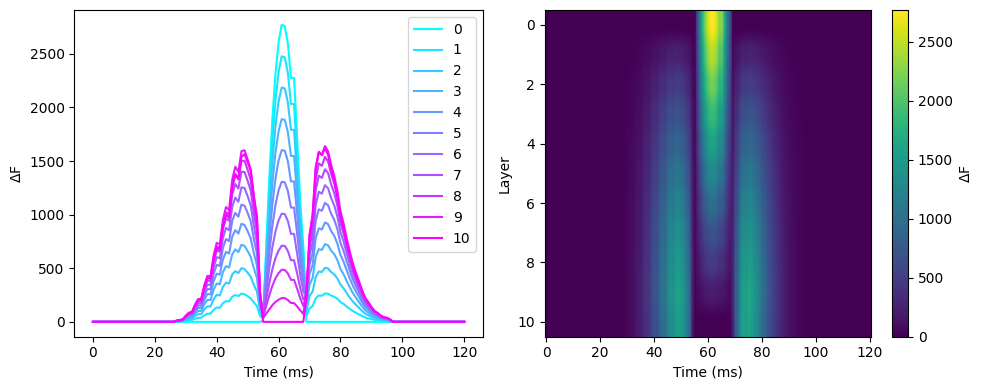

In [21]:
# Compute the relative free energy for each layer model, compared to the worst model at each time step
F_diff = np.zeros((Fs.shape[0],Fs.shape[1]))
for t in range(Fs.shape[1]):
    minF = np.min(Fs[:,t])
    F_diff[:,t] = Fs[:,t]-minF
    
col_r = plt.cm.cool(np.linspace(0,1, num=surf_set.n_layers))
plt.figure(figsize=(10,4))

# Plot relative free energy time series
plt.subplot(1,2,1)
for l in range(surf_set.n_layers):
    plt.plot(F_diff[l,:], label=f'{l}', color=col_r[l,:])
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')

plt.subplot(1,2,2)
h=plt.imshow(F_diff,aspect='auto')
plt.xlabel('Time (ms)')
plt.ylabel('Layer')
col_r=plt.colorbar(h)
col_r.set_label(r'$\Delta$F')
plt.tight_layout()

In [22]:
spm.terminate()

# Delete simulation files
shutil.rmtree(tmp_dir)